In [1]:
import os
# os.environ["CUDA_VISIBLE_DEVICES"] = "0"
import numpy as np
from netCDF4 import Dataset

import seaborn as sns



import matplotlib.pyplot as plt

path = os.getcwd()

import tensorflow as tf
from tensorflow.python.client import device_lib

print(tf.__version__)
print(device_lib.list_local_devices())

import xgboost as xgb
import pickle

2.8.0
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 1827355894848503965
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 3645898752
locality {
  bus_id: 1
  links {
  }
}
incarnation: 1373350158550517471
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6"
xla_global_id: 416903419
]


### 데이터셋 구축

In [2]:
# In[] SMOKE-CMAQ
# CMAQ 연평균 PM농도
pm2_5 = np.array([])

for i in range(1,120):
    a = 'ACONC.' + str(i)
    nc = Dataset(a, 'r')
    pm2_5 = np.append(pm2_5, np.array([[[nc.variables['PM2_5']]]]))
    
pm2_5 = np.reshape(pm2_5, [119,82,67])
pm2_5 = pm2_5[:,8:-10,2:-1]
pm2_5 = np.reshape(pm2_5, [119,64,64]) # convolution 연산을 위해

pm = pm2_5


y1 = np.array([])
y2 = np.array([])
y3 = np.array([])
y4 = np.array([])
y5 = np.array([])
y6 = np.array([])

for i in range(1,120):
    a = 'EMIS_AVG.' + str(i)
    nc = Dataset(a, 'r')
    y1 = np.append(y1, np.array([[[nc.variables['SO2']]]]))
    y2 = np.append(y2, np.array([[[nc.variables['PM2_5']]]]))
    y3 = np.append(y3, np.array([[[nc.variables['NOx']]]]))
    y4 = np.append(y4, np.array([[[nc.variables['VOCs']]]]))
    y5 = np.append(y5, np.array([[[nc.variables['NH3']]]]))
    y6 = np.append(y6, np.array([[[nc.variables['CO']]]]))
    
y1 = np.reshape(y1, [119,82,67])
y1 = y1[:,8:-10,2:-1]
y1 = np.reshape(y1, [119,64,64])
y1_max = np.max(y1)
y1_min = np.min(y1)

y2 = np.reshape(y2, [119,82,67])
y2 = y2[:,8:-10,2:-1]
y2 = np.reshape(y2, [119,64,64])
y2_max = np.max(y2)
y2_min = np.min(y2)

y3 = np.reshape(y3, [119,82,67])
y3 = y3[:,8:-10,2:-1]
y3 = np.reshape(y3, [119,64,64])
y3_max = np.max(y3)
y3_min = np.min(y3)

y4 = np.reshape(y4, [119,82,67])
y4 = y4[:,8:-10,2:-1]
y4 = np.reshape(y4, [119,64,64])
y4_max = np.max(y4)
y4_min = np.min(y4)

y5 = np.reshape(y5, [119,82,67])
y5 = y5[:,8:-10,2:-1]
y5 = np.reshape(y5, [119,64,64])
y5_max = np.max(y5)
y5_min = np.min(y5)
    
y6 = np.reshape(y6, [119,82,67])
y6 = y6[:,8:-10,2:-1]
y6 = np.reshape(y6, [119,64,64])


def pm_data():
    a = np.concatenate((y3,y1,y4,y5), axis=0) # PM2.5, SO2, NH3
    a = np.reshape(a,[4,119,64,64]) # data generation for CNN ??
    a = np.transpose(a, (1,2,3,0)) # CNN 학습을 위한 순서변경
    print(np.shape(a))
    
    y = pm
    
    y = np.reshape(y, [119,64,64,1]) # CNN output data
    x_train = a[0:70]
    y_train = y[0:70]
    x_test = a[70:]
    pm2_5 = y[70:]
    return x_train, y_train, x_test, pm2_5, a, y


pm_data1 = pm_data()
x_train, y_train, x_test, pm2_5, a, y = pm_data1[0], pm_data1[1], pm_data1[2], pm_data1[3], pm_data1[4], pm_data1[5]#, pm_data1[6], pm_data1[7] 


(119, 64, 64, 4)


In [3]:
x_train.shape

(70, 64, 64, 4)

### 기본 예측네트워크 구축

In [44]:
OUTPUT_CHANNELS = 1

def downsample(filters, size, apply_batchnorm=True):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
      tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))

  if apply_batchnorm:
    result.add(tf.keras.layers.BatchNormalization())

  result.add(tf.keras.layers.LeakyReLU())

  return result

def upsample(filters, size, apply_dropout=False):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
    tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                    padding='same',
                                    kernel_initializer=initializer,
                                    use_bias=False))

  result.add(tf.keras.layers.BatchNormalization())

  if apply_dropout:
      result.add(tf.keras.layers.Dropout(0.5))

  result.add(tf.keras.layers.ReLU())

  return result

def Unet():
  # data_augmentation = tf.keras.Sequential([
  #   # tf.keras.layers.RandomFlip('horizontal'), # "horizontal", "vertical", or "horizontal_and_vertical"
  #   # tf.keras.layers.RandomRotation(0.2),
  #   tf.keras.layers.GaussianNoise(   # 노이즈레이어 이부분도 학습에서만 활성화됨
  #       1, seed=None,
  #   )
  #   ])




  inputs = tf.keras.layers.Input(shape=[64, 64, 4])

  down_stack = [
    downsample(64, 3),  # (batch_size, 64, 64, 64)
    downsample(128, 3),  # (batch_size, 32, 32, 128)
    downsample(256, 3),  # (batch_size, 16, 16, 256)
    downsample(512, 3),  # (batch_size, 8, 8, 512)
    downsample(512, 3),  # (batch_size, 4, 4, 512)
  ]

  up_stack = [
    upsample(512, 3, apply_dropout=True),  # (batch_size, 4, 4, 1024)
    upsample(512, 3),  # (batch_size, 8, 8, 1024)
    upsample(256, 3),  # (batch_size, 16, 16, 512)
    upsample(128, 3),  # (batch_size, 32, 32, 256)
    upsample(64, 3),  # (batch_size, 64, 64, 128)
  ]

  initializer = tf.random_normal_initializer(0., 0.02)
  last = tf.keras.layers.Conv2DTranspose(OUTPUT_CHANNELS, 2,
                                         strides=2,
                                         padding='same',
                                         kernel_initializer=initializer,
                                         )  # (batch_size, 256, 256, 3)  activation='tanh'

  x = inputs
  # x = data_augmentation(x)      

  # Downsampling through the model
  skips = []
  for down in down_stack:
    x = down(x)
    skips.append(x)

  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    x = tf.keras.layers.Concatenate()([x, skip])

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

In [45]:
x_train_tensor = tf.convert_to_tensor(x_train,dtype = float)
x_test_tensor = tf.convert_to_tensor(x_test,dtype = float)
y_train_resize_tensor = tf.convert_to_tensor(y_train,dtype = float)
y_test_resize_tensor = tf.convert_to_tensor(pm2_5,dtype = float)

batch_size = 20
epoch = 1000
buffer_len = len(x_train_tensor)
n_run = np.ceil(len(x_train_tensor)/batch_size)
print(f'배치사이즈: {batch_size}, 에폭당 학습수: {n_run}, 에폭: {epoch}')

train_dataset = tf.data.Dataset.zip((tf.data.Dataset.from_tensor_slices(x_train_tensor), tf.data.Dataset.from_tensor_slices(y_train_resize_tensor),))
shuffled_dataset = train_dataset.shuffle(buffer_size=buffer_len)

net_1 = Unet()
# test_net = Unet()
# pred = test_net(x_train)

배치사이즈: 20, 에폭당 학습수: 4.0, 에폭: 1000


In [46]:
@tf.function()
def train_step(input, label, network, loss_fun):
  
  with tf.GradientTape() as tape:
    ##로스 계산
    pred = network(input)
    
    loss = loss_fun(label, pred)
  grads = tape.gradient(loss, network.trainable_variables)
  optimizer.apply_gradients(zip(grads, network.trainable_variables))
  return loss



loss = tf.keras.losses.MeanSquaredError()
optimizer = tf.keras.optimizers.Adam(0.00005)

for epoc in range(epoch):
    count = 0

    for batch in shuffled_dataset.batch(batch_size).take(n_run):

        count += 1
        mse_loss = train_step(batch[0],batch[1], net_1,loss).numpy()
        print(f"batch: {count}/{n_run} ---epoch: {epoc}/{epoch}--- mse-loss: {mse_loss}")

batch: 1/4.0 ---epoch: 0/1000--- mse-loss: 177.8851776123047
batch: 2/4.0 ---epoch: 0/1000--- mse-loss: 177.214111328125
batch: 3/4.0 ---epoch: 0/1000--- mse-loss: 178.3583221435547
batch: 4/4.0 ---epoch: 0/1000--- mse-loss: 178.26608276367188
batch: 1/4.0 ---epoch: 1/1000--- mse-loss: 175.8260955810547
batch: 2/4.0 ---epoch: 1/1000--- mse-loss: 180.33799743652344
batch: 3/4.0 ---epoch: 1/1000--- mse-loss: 178.71856689453125
batch: 4/4.0 ---epoch: 1/1000--- mse-loss: 175.1934051513672
batch: 1/4.0 ---epoch: 2/1000--- mse-loss: 177.71099853515625
batch: 2/4.0 ---epoch: 2/1000--- mse-loss: 178.3056640625
batch: 3/4.0 ---epoch: 2/1000--- mse-loss: 178.3840789794922
batch: 4/4.0 ---epoch: 2/1000--- mse-loss: 175.9065704345703
batch: 1/4.0 ---epoch: 3/1000--- mse-loss: 178.9952850341797
batch: 2/4.0 ---epoch: 3/1000--- mse-loss: 176.6884307861328
batch: 3/4.0 ---epoch: 3/1000--- mse-loss: 176.98361206054688
batch: 4/4.0 ---epoch: 3/1000--- mse-loss: 179.04678344726562
batch: 1/4.0 ---epoch:

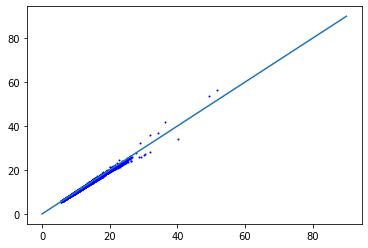

In [47]:
pre = net_1(x_test_tensor)
plt.plot(pre.numpy()[0][::-1].reshape(-1), y_test_resize_tensor.numpy()[0][::-1].reshape(-1),'bo', markersize=1)
plt.plot([0,90],[0,90])


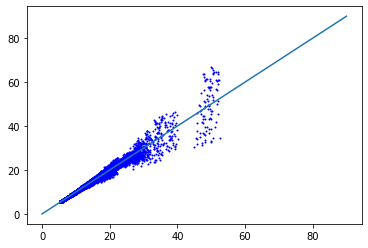

In [48]:
plt.plot(pre.numpy()[::-1].reshape(-1), y_test_resize_tensor.numpy()[::-1].reshape(-1),'bo', markersize=1)
plt.plot([0,90],[0,90])

<AxesSubplot: >

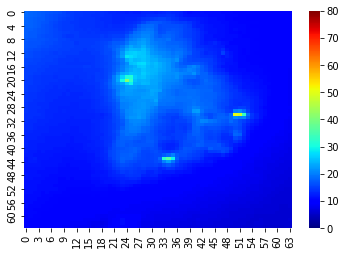

In [42]:
sns.heatmap(pre.numpy()[0,:,:,0][::-1], cmap = 'jet',vmin=0, vmax=80)

<AxesSubplot: >

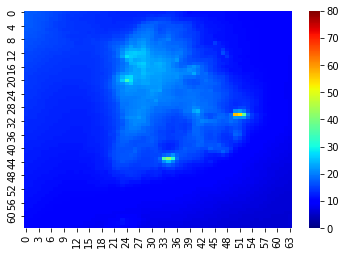

In [43]:
sns.heatmap(y_test_resize_tensor.numpy()[0,:,:,0][::-1], cmap = 'jet',vmin=0, vmax=80)

In [50]:
tf.keras.layers.Conv2D(10, 3, activation='relu', padding='same')(x_test_tensor)

<tf.Tensor: shape=(49, 64, 64, 10), dtype=float32, numpy=
array([[[[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],

        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],

        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],

        ...,

        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ...,

In [51]:
tf.keras.layers.Conv2D(10, 3, strides=2, activation='relu', padding='same')(x_test_tensor)

<tf.Tensor: shape=(49, 32, 32, 10), dtype=float32, numpy=
array([[[[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],

        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],

        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],

        ...,

        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ...,

### 맥스풀링 더한 네트워크 구축/ padding='same',으로처리 스트라이드 안하고

In [52]:
OUTPUT_CHANNELS = 1

def downsample(filters, size, apply_batchnorm=True):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
      tf.keras.layers.Conv2D(filters, size, padding='same',
                             kernel_initializer=initializer, use_bias=False))

  if apply_batchnorm:
    result.add(tf.keras.layers.BatchNormalization())

  result.add(tf.keras.layers.LeakyReLU())
  result.add(tf.keras.layers.MaxPool2D(pool_size=(2,2),))

  return result

def upsample(filters, size, apply_dropout=False):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
    tf.keras.layers.Conv2DTranspose(filters, size,
                                    padding='same',
                                    kernel_initializer=initializer,
                                    use_bias=False))

  result.add(tf.keras.layers.BatchNormalization())

  if apply_dropout:
      result.add(tf.keras.layers.Dropout(0.5))

  result.add(tf.keras.layers.ReLU())
  result.add(tf.keras.layers.Conv2DTranspose(filters=512, kernel_size=2,strides=(2, 2)))

  return result

def Unet():
  # data_augmentation = tf.keras.Sequential([
  #   # tf.keras.layers.RandomFlip('horizontal'), # "horizontal", "vertical", or "horizontal_and_vertical"
  #   # tf.keras.layers.RandomRotation(0.2),
  #   tf.keras.layers.GaussianNoise(   # 노이즈레이어 이부분도 학습에서만 활성화됨
  #       1, seed=None,
  #   )
  #   ])




  inputs = tf.keras.layers.Input(shape=[64, 64, 4])

  down_stack = [
    downsample(64, 3),  # (batch_size, 64, 64, 64)
    downsample(128, 3),  # (batch_size, 32, 32, 128)
    downsample(256, 3),  # (batch_size, 16, 16, 256)
    downsample(512, 3),  # (batch_size, 8, 8, 512)
    downsample(512, 3),  # (batch_size, 4, 4, 512)
  ]

  up_stack = [
    upsample(512, 3, apply_dropout=True),  # (batch_size, 4, 4, 1024)
    upsample(512, 3),  # (batch_size, 8, 8, 1024)
    upsample(256, 3),  # (batch_size, 16, 16, 512)
    upsample(128, 3),  # (batch_size, 32, 32, 256)
    upsample(64, 3),  # (batch_size, 64, 64, 128)
  ]

  initializer = tf.random_normal_initializer(0., 0.02)
  last = tf.keras.layers.Conv2DTranspose(OUTPUT_CHANNELS, 2,
                                         strides=2,
                                         padding='same',
                                         kernel_initializer=initializer,
                                         )  # (batch_size, 256, 256, 3)  activation='tanh'

  x = inputs
  # x = data_augmentation(x)      

  # Downsampling through the model
  skips = []
  for down in down_stack:
    x = down(x)
    skips.append(x)

  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    x = tf.keras.layers.Concatenate()([x, skip])

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

In [53]:
x_train_tensor = tf.convert_to_tensor(x_train,dtype = float)
x_test_tensor = tf.convert_to_tensor(x_test,dtype = float)
y_train_resize_tensor = tf.convert_to_tensor(y_train,dtype = float)
y_test_resize_tensor = tf.convert_to_tensor(pm2_5,dtype = float)

batch_size = 20
epoch = 1000
buffer_len = len(x_train_tensor)
n_run = np.ceil(len(x_train_tensor)/batch_size)
print(f'배치사이즈: {batch_size}, 에폭당 학습수: {n_run}, 에폭: {epoch}')

train_dataset = tf.data.Dataset.zip((tf.data.Dataset.from_tensor_slices(x_train_tensor), tf.data.Dataset.from_tensor_slices(y_train_resize_tensor),))
shuffled_dataset = train_dataset.shuffle(buffer_size=buffer_len)

net_1 = Unet()
# test_net = Unet()
# pred = test_net(x_train)

배치사이즈: 20, 에폭당 학습수: 4.0, 에폭: 1000


In [54]:
@tf.function()
def train_step(input, label, network, loss_fun):
  
  with tf.GradientTape() as tape:
    ##로스 계산
    pred = network(input)
    
    loss = loss_fun(label, pred)
  grads = tape.gradient(loss, network.trainable_variables)
  optimizer.apply_gradients(zip(grads, network.trainable_variables))
  return loss



loss = tf.keras.losses.MeanSquaredError()
optimizer = tf.keras.optimizers.Adam(0.00005)

for epoc in range(epoch):
    count = 0

    for batch in shuffled_dataset.batch(batch_size).take(n_run):

        count += 1
        mse_loss = train_step(batch[0],batch[1], net_1,loss).numpy()
        print(f"batch: {count}/{n_run} ---epoch: {epoc}/{epoch}--- mse-loss: {mse_loss}")

batch: 1/4.0 ---epoch: 0/1000--- mse-loss: 177.29844665527344
batch: 2/4.0 ---epoch: 0/1000--- mse-loss: 177.1495361328125
batch: 3/4.0 ---epoch: 0/1000--- mse-loss: 178.7715606689453
batch: 4/4.0 ---epoch: 0/1000--- mse-loss: 178.2745361328125
batch: 1/4.0 ---epoch: 1/1000--- mse-loss: 177.6754608154297
batch: 2/4.0 ---epoch: 1/1000--- mse-loss: 178.91000366210938
batch: 3/4.0 ---epoch: 1/1000--- mse-loss: 176.40176391601562
batch: 4/4.0 ---epoch: 1/1000--- mse-loss: 177.4600372314453
batch: 1/4.0 ---epoch: 2/1000--- mse-loss: 177.30142211914062
batch: 2/4.0 ---epoch: 2/1000--- mse-loss: 177.13449096679688
batch: 3/4.0 ---epoch: 2/1000--- mse-loss: 176.9104766845703
batch: 4/4.0 ---epoch: 2/1000--- mse-loss: 177.4260711669922
batch: 1/4.0 ---epoch: 3/1000--- mse-loss: 175.63392639160156
batch: 2/4.0 ---epoch: 3/1000--- mse-loss: 175.4392852783203
batch: 3/4.0 ---epoch: 3/1000--- mse-loss: 175.55239868164062
batch: 4/4.0 ---epoch: 3/1000--- mse-loss: 174.90296936035156
batch: 1/4.0 ---

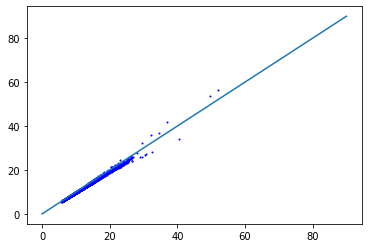

In [55]:
pre = net_1(x_test_tensor)
plt.plot(pre.numpy()[0][::-1].reshape(-1), y_test_resize_tensor.numpy()[0][::-1].reshape(-1),'bo', markersize=1)
plt.plot([0,90],[0,90])

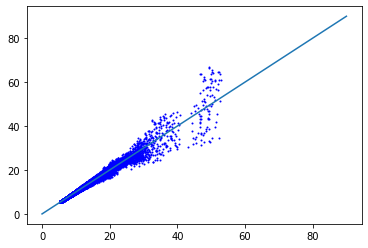

In [56]:
plt.plot(pre.numpy()[::-1].reshape(-1), y_test_resize_tensor.numpy()[::-1].reshape(-1),'bo', markersize=1)
plt.plot([0,90],[0,90])

<AxesSubplot: >

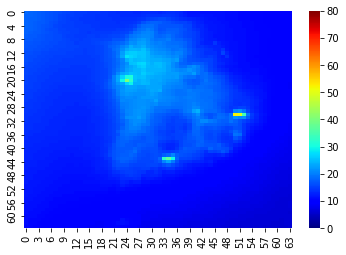

In [57]:
sns.heatmap(pre.numpy()[0,:,:,0][::-1], cmap = 'jet',vmin=0, vmax=80)

<AxesSubplot: >

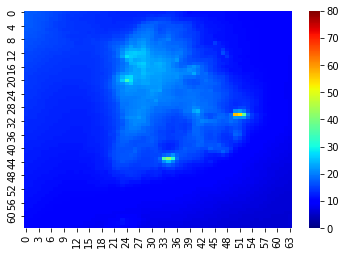

In [58]:
sns.heatmap(y_test_resize_tensor.numpy()[0,:,:,0][::-1], cmap = 'jet',vmin=0, vmax=80)

### 사이사이에 사이즈 안바뀌는 컨볼루션 넣기

In [59]:
OUTPUT_CHANNELS = 1

def downsample(filters, size, apply_batchnorm=True):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  # 이부분은 사이즈 안변하는 연산
  result.add(
      tf.keras.layers.Conv2D(filters, size,padding='same',
                             kernel_initializer=initializer, use_bias=False))

  if apply_batchnorm:
    result.add(tf.keras.layers.BatchNormalization())

  result.add(tf.keras.layers.LeakyReLU())

  # 여기서 픽셀사이즈 절반으로 (스트라이드)
  # 맥스풀링으로 대체해도 됨
  result.add(
      tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))

  return result

def upsample(filters, size, apply_dropout=False):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  # 사이즈 안변하게 컨볼루션연산 한번
  result.add(
      tf.keras.layers.Conv2D(filters, size,padding='same',
                             kernel_initializer=initializer, use_bias=False))




  # 이부분이 업샘플
  result.add(
    tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                    padding='same',
                                    kernel_initializer=initializer,
                                    use_bias=False))

  result.add(tf.keras.layers.BatchNormalization())

  if apply_dropout:
      result.add(tf.keras.layers.Dropout(0.5))

  result.add(tf.keras.layers.ReLU())

  return result

def Unet():
  # data_augmentation = tf.keras.Sequential([
  #   # tf.keras.layers.RandomFlip('horizontal'), # "horizontal", "vertical", or "horizontal_and_vertical"
  #   # tf.keras.layers.RandomRotation(0.2),
  #   tf.keras.layers.GaussianNoise(   # 노이즈레이어 이부분도 학습에서만 활성화됨
  #       1, seed=None,
  #   )
  #   ])




  inputs = tf.keras.layers.Input(shape=[64, 64, 4])

  down_stack = [
    downsample(64, 3),  # (batch_size, 64, 64, 64)
    downsample(128, 3),  # (batch_size, 32, 32, 128)
    downsample(256, 3),  # (batch_size, 16, 16, 256)
    downsample(512, 3),  # (batch_size, 8, 8, 512)
    downsample(512, 3),  # (batch_size, 4, 4, 512)
  ]

  up_stack = [
    upsample(512, 3, apply_dropout=True),  # (batch_size, 4, 4, 1024)
    upsample(512, 3),  # (batch_size, 8, 8, 1024)
    upsample(256, 3),  # (batch_size, 16, 16, 512)
    upsample(128, 3),  # (batch_size, 32, 32, 256)
    upsample(64, 3),  # (batch_size, 64, 64, 128)
  ]

  initializer = tf.random_normal_initializer(0., 0.02)
  last = tf.keras.layers.Conv2DTranspose(OUTPUT_CHANNELS, 2,
                                         strides=2,
                                         padding='same',
                                         kernel_initializer=initializer,
                                         )  # (batch_size, 256, 256, 3)  activation='tanh'

  x = inputs
  # x = data_augmentation(x)      

  # Downsampling through the model
  skips = []
  for down in down_stack:
    x = down(x)
    skips.append(x)

  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    x = tf.keras.layers.Concatenate()([x, skip])

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

In [60]:
x_train_tensor = tf.convert_to_tensor(x_train,dtype = float)
x_test_tensor = tf.convert_to_tensor(x_test,dtype = float)
y_train_resize_tensor = tf.convert_to_tensor(y_train,dtype = float)
y_test_resize_tensor = tf.convert_to_tensor(pm2_5,dtype = float)

batch_size = 20
epoch = 1000
buffer_len = len(x_train_tensor)
n_run = np.ceil(len(x_train_tensor)/batch_size)
print(f'배치사이즈: {batch_size}, 에폭당 학습수: {n_run}, 에폭: {epoch}')

train_dataset = tf.data.Dataset.zip((tf.data.Dataset.from_tensor_slices(x_train_tensor), tf.data.Dataset.from_tensor_slices(y_train_resize_tensor),))
shuffled_dataset = train_dataset.shuffle(buffer_size=buffer_len)

net_1 = Unet()
# test_net = Unet()
# pred = test_net(x_train)

배치사이즈: 20, 에폭당 학습수: 4.0, 에폭: 1000


In [61]:
@tf.function()
def train_step(input, label, network, loss_fun):
  
  with tf.GradientTape() as tape:
    ##로스 계산
    pred = network(input)
    
    loss = loss_fun(label, pred)
  grads = tape.gradient(loss, network.trainable_variables)
  optimizer.apply_gradients(zip(grads, network.trainable_variables))
  return loss



loss = tf.keras.losses.MeanSquaredError()
optimizer = tf.keras.optimizers.Adam(0.00005)

for epoc in range(epoch):
    count = 0

    for batch in shuffled_dataset.batch(batch_size).take(n_run):

        count += 1
        mse_loss = train_step(batch[0],batch[1], net_1,loss).numpy()
        print(f"batch: {count}/{n_run} ---epoch: {epoc}/{epoch}--- mse-loss: {mse_loss}")

batch: 1/4.0 ---epoch: 0/1000--- mse-loss: 176.81642150878906
batch: 2/4.0 ---epoch: 0/1000--- mse-loss: 179.19766235351562
batch: 3/4.0 ---epoch: 0/1000--- mse-loss: 178.19381713867188
batch: 4/4.0 ---epoch: 0/1000--- mse-loss: 176.60317993164062
batch: 1/4.0 ---epoch: 1/1000--- mse-loss: 176.61630249023438
batch: 2/4.0 ---epoch: 1/1000--- mse-loss: 178.77145385742188
batch: 3/4.0 ---epoch: 1/1000--- mse-loss: 177.8242645263672
batch: 4/4.0 ---epoch: 1/1000--- mse-loss: 178.31138610839844
batch: 1/4.0 ---epoch: 2/1000--- mse-loss: 177.1257781982422
batch: 2/4.0 ---epoch: 2/1000--- mse-loss: 179.01551818847656
batch: 3/4.0 ---epoch: 2/1000--- mse-loss: 177.12747192382812
batch: 4/4.0 ---epoch: 2/1000--- mse-loss: 177.79690551757812
batch: 1/4.0 ---epoch: 3/1000--- mse-loss: 180.143798828125
batch: 2/4.0 ---epoch: 3/1000--- mse-loss: 176.91213989257812
batch: 3/4.0 ---epoch: 3/1000--- mse-loss: 176.38449096679688
batch: 4/4.0 ---epoch: 3/1000--- mse-loss: 176.17611694335938
batch: 1/4.0

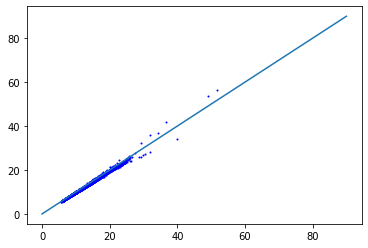

In [62]:
pre = net_1(x_test_tensor)
plt.plot(pre.numpy()[0][::-1].reshape(-1), y_test_resize_tensor.numpy()[0][::-1].reshape(-1),'bo', markersize=1)
plt.plot([0,90],[0,90])

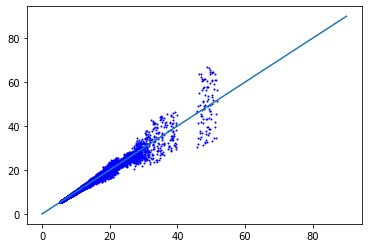

In [63]:
plt.plot(pre.numpy()[::-1].reshape(-1), y_test_resize_tensor.numpy()[::-1].reshape(-1),'bo', markersize=1)
plt.plot([0,90],[0,90])

<AxesSubplot: >

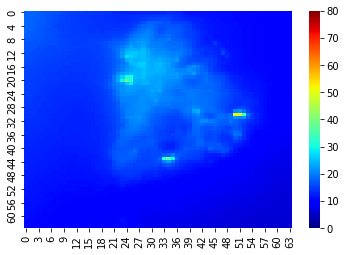

In [64]:
sns.heatmap(pre.numpy()[0,:,:,0][::-1], cmap = 'jet',vmin=0, vmax=80)

<AxesSubplot: >

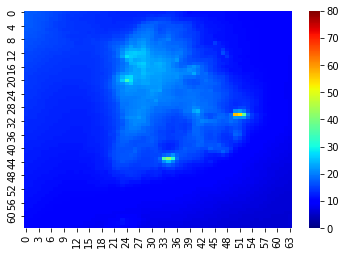

In [65]:
sns.heatmap(y_test_resize_tensor.numpy()[0,:,:,0][::-1], cmap = 'jet',vmin=0, vmax=80)

### 다운샘플부분 맥스풀링으로 넣기

In [85]:
OUTPUT_CHANNELS = 1

def downsample(filters, size, apply_batchnorm=True):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  # 이부분은 사이즈 안변하는 연산
  result.add(
      tf.keras.layers.Conv2D(filters, size,padding='same',
                             kernel_initializer=initializer, use_bias=False))

  if apply_batchnorm:
    result.add(tf.keras.layers.BatchNormalization())

  result.add(tf.keras.layers.LeakyReLU())

  # 여기서 픽셀사이즈 절반으로 (스트라이드)
  # 맥스풀링으로 대체해도 됨
  result.add(
      tf.keras.layers.MaxPool2D(pool_size=(2,2),))

  return result

def upsample(filters, size, apply_dropout=False):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  # 사이즈 안변하게 컨볼루션연산 한번
  result.add(
      tf.keras.layers.Conv2D(filters, size,padding='same',
                             kernel_initializer=initializer, use_bias=False))




  # 이부분이 업샘플
  result.add(
    tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                    padding='same',
                                    kernel_initializer=initializer,
                                    use_bias=False))

  result.add(tf.keras.layers.BatchNormalization())

  if apply_dropout:
      result.add(tf.keras.layers.Dropout(0.5))

  result.add(tf.keras.layers.ReLU())

  return result

def Unet():
  # data_augmentation = tf.keras.Sequential([
  #   # tf.keras.layers.RandomFlip('horizontal'), # "horizontal", "vertical", or "horizontal_and_vertical"
  #   # tf.keras.layers.RandomRotation(0.2),
  #   tf.keras.layers.GaussianNoise(   # 노이즈레이어 이부분도 학습에서만 활성화됨
  #       1, seed=None,
  #   )
  #   ])




  inputs = tf.keras.layers.Input(shape=[64, 64, 4])

  down_stack = [
    downsample(64, 3),  # (batch_size, 64, 64, 64)
    downsample(128, 3),  # (batch_size, 32, 32, 128)
    downsample(256, 3),  # (batch_size, 16, 16, 256)
    downsample(512, 3),  # (batch_size, 8, 8, 512)
    downsample(512, 3),  # (batch_size, 4, 4, 512)
  ]

  up_stack = [
    upsample(512, 3, apply_dropout=True),  # (batch_size, 4, 4, 1024)
    upsample(512, 3),  # (batch_size, 8, 8, 1024)
    upsample(256, 3),  # (batch_size, 16, 16, 512)
    upsample(128, 3),  # (batch_size, 32, 32, 256)
    upsample(64, 3),  # (batch_size, 64, 64, 128)
  ]

  initializer = tf.random_normal_initializer(0., 0.02)
  last = tf.keras.layers.Conv2DTranspose(OUTPUT_CHANNELS, 2,
                                         strides=2,
                                         padding='same',
                                         kernel_initializer=initializer,
                                         )  # (batch_size, 256, 256, 3)  activation='tanh'

  x = inputs
  # x = data_augmentation(x)      

  # Downsampling through the model
  skips = []
  for down in down_stack:
    x = down(x)
    skips.append(x)

  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    x = tf.keras.layers.Concatenate()([x, skip])

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

In [86]:
x_train_tensor = tf.convert_to_tensor(x_train,dtype = float)
x_test_tensor = tf.convert_to_tensor(x_test,dtype = float)
y_train_resize_tensor = tf.convert_to_tensor(y_train,dtype = float)
y_test_resize_tensor = tf.convert_to_tensor(pm2_5,dtype = float)

batch_size = 20
epoch = 500
buffer_len = len(x_train_tensor)
n_run = np.ceil(len(x_train_tensor)/batch_size)
print(f'배치사이즈: {batch_size}, 에폭당 학습수: {n_run}, 에폭: {epoch}')

train_dataset = tf.data.Dataset.zip((tf.data.Dataset.from_tensor_slices(x_train_tensor), tf.data.Dataset.from_tensor_slices(y_train_resize_tensor),))
shuffled_dataset = train_dataset.shuffle(buffer_size=buffer_len)

net_1 = Unet()
# test_net = Unet()
# pred = test_net(x_train)

배치사이즈: 20, 에폭당 학습수: 4.0, 에폭: 500


In [87]:
@tf.function()
def train_step(input, label, network, loss_fun):
  
  with tf.GradientTape() as tape:
    ##로스 계산
    pred = network(input)
    
    loss = loss_fun(label, pred)
  grads = tape.gradient(loss, network.trainable_variables)
  optimizer.apply_gradients(zip(grads, network.trainable_variables))
  return loss



loss = tf.keras.losses.MeanSquaredError()
optimizer = tf.keras.optimizers.Adam(0.00005)

for epoc in range(epoch):
    count = 0

    for batch in shuffled_dataset.batch(batch_size).take(n_run):

        count += 1
        mse_loss = train_step(batch[0],batch[1], net_1,loss).numpy()
        print(f"batch: {count}/{n_run} ---epoch: {epoc}/{epoch}--- mse-loss: {mse_loss}")

batch: 1/4.0 ---epoch: 0/500--- mse-loss: 177.23922729492188
batch: 2/4.0 ---epoch: 0/500--- mse-loss: 179.07870483398438
batch: 3/4.0 ---epoch: 0/500--- mse-loss: 178.25979614257812
batch: 4/4.0 ---epoch: 0/500--- mse-loss: 175.49441528320312
batch: 1/4.0 ---epoch: 1/500--- mse-loss: 180.13623046875
batch: 2/4.0 ---epoch: 1/500--- mse-loss: 176.30810546875
batch: 3/4.0 ---epoch: 1/500--- mse-loss: 177.13900756835938
batch: 4/4.0 ---epoch: 1/500--- mse-loss: 177.02667236328125
batch: 1/4.0 ---epoch: 2/500--- mse-loss: 177.37423706054688
batch: 2/4.0 ---epoch: 2/500--- mse-loss: 178.3022003173828
batch: 3/4.0 ---epoch: 2/500--- mse-loss: 177.24412536621094
batch: 4/4.0 ---epoch: 2/500--- mse-loss: 177.48377990722656
batch: 1/4.0 ---epoch: 3/500--- mse-loss: 177.2386932373047
batch: 2/4.0 ---epoch: 3/500--- mse-loss: 178.46682739257812
batch: 3/4.0 ---epoch: 3/500--- mse-loss: 175.950927734375
batch: 4/4.0 ---epoch: 3/500--- mse-loss: 176.95950317382812
batch: 1/4.0 ---epoch: 4/500--- ms

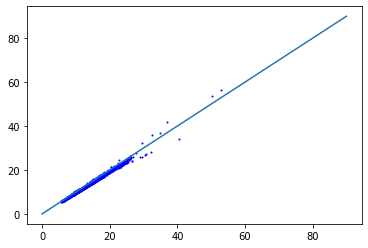

In [88]:
pre = net_1(x_test_tensor)
plt.plot(pre.numpy()[0][::-1].reshape(-1), y_test_resize_tensor.numpy()[0][::-1].reshape(-1),'bo', markersize=1)
plt.plot([0,90],[0,90])

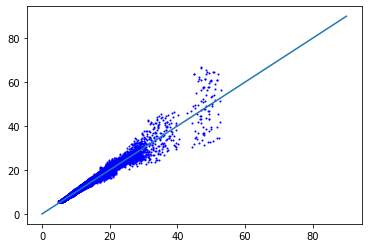

In [89]:
plt.plot(pre.numpy()[::-1].reshape(-1), y_test_resize_tensor.numpy()[::-1].reshape(-1),'bo', markersize=1)
plt.plot([0,90],[0,90])

<AxesSubplot: >

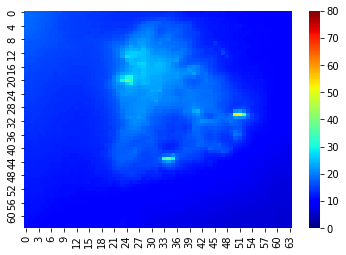

In [90]:
sns.heatmap(pre.numpy()[0,:,:,0][::-1], cmap = 'jet',vmin=0, vmax=80)

<AxesSubplot: >

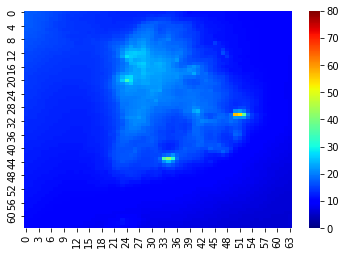

In [91]:
sns.heatmap(y_test_resize_tensor.numpy()[0,:,:,0][::-1], cmap = 'jet',vmin=0, vmax=80)

### 기본Unet에서 깊이 조정하기

In [74]:
OUTPUT_CHANNELS = 1

def downsample(filters, size, apply_batchnorm=True):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
      tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))

  if apply_batchnorm:
    result.add(tf.keras.layers.BatchNormalization())

  result.add(tf.keras.layers.LeakyReLU())

  return result

def upsample(filters, size, apply_dropout=False):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
    tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                    padding='same',
                                    kernel_initializer=initializer,
                                    use_bias=False))

  result.add(tf.keras.layers.BatchNormalization())

  if apply_dropout:
      result.add(tf.keras.layers.Dropout(0.5))

  result.add(tf.keras.layers.ReLU())

  return result

def Unet():
  # data_augmentation = tf.keras.Sequential([
  #   # tf.keras.layers.RandomFlip('horizontal'), # "horizontal", "vertical", or "horizontal_and_vertical"
  #   # tf.keras.layers.RandomRotation(0.2),
  #   tf.keras.layers.GaussianNoise(   # 노이즈레이어 이부분도 학습에서만 활성화됨
  #       1, seed=None,
  #   )
  #   ])




  inputs = tf.keras.layers.Input(shape=[64, 64, 4])

  down_stack = [
    downsample(64, 3),  # (batch_size, 64, 64, 64)
    downsample(128, 3),  # (batch_size, 32, 32, 128)
    downsample(256, 3),  # (batch_size, 16, 16, 256)
  ]

  up_stack = [
    upsample(256, 3),  # (batch_size, 16, 16, 512), apply_dropout=Tru
    upsample(128, 3),  # (batch_size, 32, 32, 256)
    upsample(64, 3),  # (batch_size, 64, 64, 128)
  ]

  initializer = tf.random_normal_initializer(0., 0.02)
  last = tf.keras.layers.Conv2DTranspose(OUTPUT_CHANNELS, 2,
                                         strides=2,
                                         padding='same',
                                         kernel_initializer=initializer,
                                         )  # (batch_size, 256, 256, 3)  activation='tanh'

  x = inputs
  # x = data_augmentation(x)      

  # Downsampling through the model
  skips = []
  for down in down_stack:
    x = down(x)
    skips.append(x)

  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    x = tf.keras.layers.Concatenate()([x, skip])

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

In [79]:
x_train_tensor = tf.convert_to_tensor(x_train,dtype = float)
x_test_tensor = tf.convert_to_tensor(x_test,dtype = float)
y_train_resize_tensor = tf.convert_to_tensor(y_train,dtype = float)
y_test_resize_tensor = tf.convert_to_tensor(pm2_5,dtype = float)

batch_size = 20
epoch = 500
buffer_len = len(x_train_tensor)
n_run = np.ceil(len(x_train_tensor)/batch_size)
print(f'배치사이즈: {batch_size}, 에폭당 학습수: {n_run}, 에폭: {epoch}')

train_dataset = tf.data.Dataset.zip((tf.data.Dataset.from_tensor_slices(x_train_tensor), tf.data.Dataset.from_tensor_slices(y_train_resize_tensor),))
shuffled_dataset = train_dataset.shuffle(buffer_size=buffer_len)

net_1 = Unet()
# test_net = Unet()
# pred = test_net(x_train)

배치사이즈: 20, 에폭당 학습수: 4.0, 에폭: 500


In [80]:
@tf.function()
def train_step(input, label, network, loss_fun):
  
  with tf.GradientTape() as tape:
    ##로스 계산
    pred = network(input)
    
    loss = loss_fun(label, pred)
  grads = tape.gradient(loss, network.trainable_variables)
  optimizer.apply_gradients(zip(grads, network.trainable_variables))
  return loss



loss = tf.keras.losses.MeanSquaredError()
optimizer = tf.keras.optimizers.Adam(0.0001)

for epoc in range(epoch):
    count = 0

    for batch in shuffled_dataset.batch(batch_size).take(n_run):

        count += 1
        mse_loss = train_step(batch[0],batch[1], net_1,loss).numpy()
        print(f"batch: {count}/{n_run} ---epoch: {epoc}/{epoch}--- mse-loss: {mse_loss}")

batch: 1/4.0 ---epoch: 0/500--- mse-loss: 177.0350341796875
batch: 2/4.0 ---epoch: 0/500--- mse-loss: 179.4769744873047
batch: 3/4.0 ---epoch: 0/500--- mse-loss: 176.9547882080078
batch: 4/4.0 ---epoch: 0/500--- mse-loss: 177.85403442382812
batch: 1/4.0 ---epoch: 1/500--- mse-loss: 178.7697296142578
batch: 2/4.0 ---epoch: 1/500--- mse-loss: 178.10086059570312
batch: 3/4.0 ---epoch: 1/500--- mse-loss: 177.3060760498047
batch: 4/4.0 ---epoch: 1/500--- mse-loss: 175.9190216064453
batch: 1/4.0 ---epoch: 2/500--- mse-loss: 177.02513122558594
batch: 2/4.0 ---epoch: 2/500--- mse-loss: 178.0341339111328
batch: 3/4.0 ---epoch: 2/500--- mse-loss: 178.10128784179688
batch: 4/4.0 ---epoch: 2/500--- mse-loss: 177.28567504882812
batch: 1/4.0 ---epoch: 3/500--- mse-loss: 178.30825805664062
batch: 2/4.0 ---epoch: 3/500--- mse-loss: 176.25071716308594
batch: 3/4.0 ---epoch: 3/500--- mse-loss: 178.13153076171875
batch: 4/4.0 ---epoch: 3/500--- mse-loss: 177.20156860351562
batch: 1/4.0 ---epoch: 4/500---

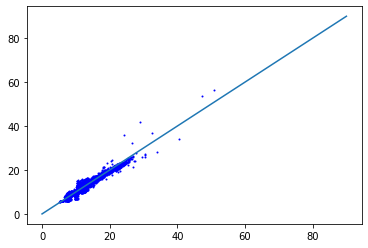

In [81]:
pre = net_1(x_test_tensor)
plt.plot(pre.numpy()[0][::-1].reshape(-1), y_test_resize_tensor.numpy()[0][::-1].reshape(-1),'bo', markersize=1)
plt.plot([0,90],[0,90])


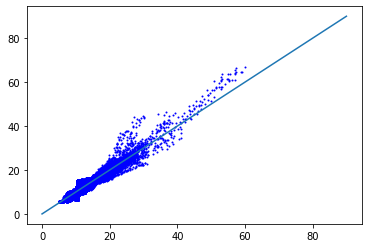

In [82]:
plt.plot(pre.numpy()[::-1].reshape(-1), y_test_resize_tensor.numpy()[::-1].reshape(-1),'bo', markersize=1)
plt.plot([0,90],[0,90])

<AxesSubplot: >

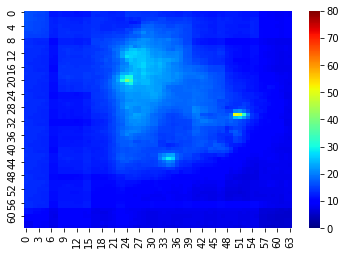

In [83]:
sns.heatmap(pre.numpy()[0,:,:,0][::-1], cmap = 'jet',vmin=0, vmax=80)

<AxesSubplot: >

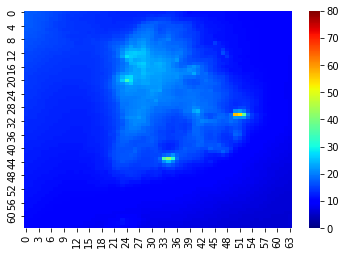

In [84]:
sns.heatmap(y_test_resize_tensor.numpy()[0,:,:,0][::-1], cmap = 'jet',vmin=0, vmax=80)

### 기본 cnn

In [146]:
OUTPUT_CHANNELS = 1

def cnnlayer(filters, size, apply_batchnorm=True):
  # initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  # 이부분은 사이즈 안변하는 연산
  result.add(
      tf.keras.layers.Conv2D(filters, kernel_size = size, padding='same', use_bias=True))

  if apply_batchnorm:
    result.add(tf.keras.layers.BatchNormalization())

  result.add(tf.keras.layers.LeakyReLU())


  return result

def Simple_cnn():
  inputs = tf.keras.layers.Input(shape=[64, 64, 4])

  stack = [
    cnnlayer(64, 3),  # (batch_size, 64, 64, 64)
    cnnlayer(128, 3),  # (batch_size, 32, 32, 128)
    cnnlayer(256, 3),  # (batch_size, 16, 16, 256)
    cnnlayer(512, 3),  # (batch_size, 8, 8, 512)
    cnnlayer(256, 3),  # (batch_size, 8, 8, 512)
    cnnlayer(64, 3),  # (batch_size, 8, 8, 512)
    # downsample(512, 3),  # (batch_size, 4, 4, 512)
  ]
  last = tf.keras.layers.Conv2D(1, 2, padding='same', use_bias=True)

 

  x = inputs
  for layer in stack:
    x = layer(x)
    print(x.shape)
  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

In [147]:
x_train_tensor = tf.convert_to_tensor(x_train,dtype = float)
x_test_tensor = tf.convert_to_tensor(x_test,dtype = float)
y_train_resize_tensor = tf.convert_to_tensor(y_train,dtype = float)
y_test_resize_tensor = tf.convert_to_tensor(pm2_5,dtype = float)

batch_size = 20
epoch = 500
buffer_len = len(x_train_tensor)
n_run = np.ceil(len(x_train_tensor)/batch_size)
print(f'배치사이즈: {batch_size}, 에폭당 학습수: {n_run}, 에폭: {epoch}')

train_dataset = tf.data.Dataset.zip((tf.data.Dataset.from_tensor_slices(x_train_tensor), tf.data.Dataset.from_tensor_slices(y_train_resize_tensor),))
shuffled_dataset = train_dataset.shuffle(buffer_size=buffer_len)

net_1 = Simple_cnn()
# test_net = Unet()
# pred = test_net(x_train)

배치사이즈: 20, 에폭당 학습수: 4.0, 에폭: 500
(None, 64, 64, 64)
(None, 64, 64, 128)
(None, 64, 64, 256)
(None, 64, 64, 512)
(None, 64, 64, 256)
(None, 64, 64, 64)


In [148]:
@tf.function()
def train_step(input, label, network, loss_fun):
  
  with tf.GradientTape() as tape:
    ##로스 계산
    pred = network(input)
    
    loss = loss_fun(label, pred)
  grads = tape.gradient(loss, network.trainable_variables)
  optimizer.apply_gradients(zip(grads, network.trainable_variables))
  return loss



loss = tf.keras.losses.MeanSquaredError()
optimizer = tf.keras.optimizers.Adam(0.00005)

for epoc in range(epoch):
    count = 0

    for batch in shuffled_dataset.batch(batch_size).take(n_run):

        count += 1
        mse_loss = train_step(batch[0],batch[1], net_1,loss).numpy()
        print(f"batch: {count}/{n_run} ---epoch: {epoc}/{epoch}--- mse-loss: {mse_loss}")

batch: 1/4.0 ---epoch: 0/500--- mse-loss: 178.9867401123047
batch: 2/4.0 ---epoch: 0/500--- mse-loss: 177.33078002929688
batch: 3/4.0 ---epoch: 0/500--- mse-loss: 174.0133514404297
batch: 4/4.0 ---epoch: 0/500--- mse-loss: 175.18527221679688
batch: 1/4.0 ---epoch: 1/500--- mse-loss: 172.14309692382812
batch: 2/4.0 ---epoch: 1/500--- mse-loss: 170.30580139160156
batch: 3/4.0 ---epoch: 1/500--- mse-loss: 169.72793579101562
batch: 4/4.0 ---epoch: 1/500--- mse-loss: 168.12261962890625
batch: 1/4.0 ---epoch: 2/500--- mse-loss: 164.1287841796875
batch: 2/4.0 ---epoch: 2/500--- mse-loss: 159.89639282226562
batch: 3/4.0 ---epoch: 2/500--- mse-loss: 156.4294891357422
batch: 4/4.0 ---epoch: 2/500--- mse-loss: 152.7592010498047
batch: 1/4.0 ---epoch: 3/500--- mse-loss: 146.74429321289062
batch: 2/4.0 ---epoch: 3/500--- mse-loss: 140.27182006835938
batch: 3/4.0 ---epoch: 3/500--- mse-loss: 134.09051513671875
batch: 4/4.0 ---epoch: 3/500--- mse-loss: 127.07783508300781
batch: 1/4.0 ---epoch: 4/500-

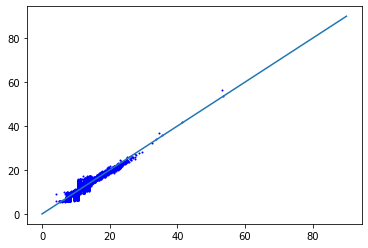

In [149]:
pre = net_1(x_test_tensor)
plt.plot(pre.numpy()[0][::-1].reshape(-1), y_test_resize_tensor.numpy()[0][::-1].reshape(-1),'bo', markersize=1)
plt.plot([0,90],[0,90])

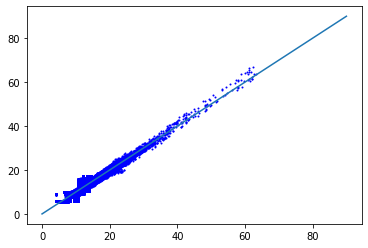

In [150]:
plt.plot(pre.numpy()[::-1].reshape(-1), y_test_resize_tensor.numpy()[::-1].reshape(-1),'bo', markersize=1)
plt.plot([0,90],[0,90])

<AxesSubplot: >

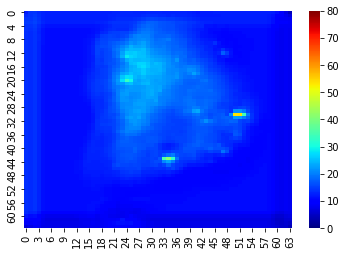

In [151]:
sns.heatmap(pre.numpy()[0,:,:,0][::-1], cmap = 'jet',vmin=0, vmax=80)

<AxesSubplot: >

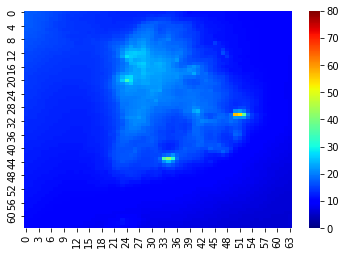

In [152]:
sns.heatmap(y_test_resize_tensor.numpy()[0,:,:,0][::-1], cmap = 'jet',vmin=0, vmax=80)

### 원본 Unet

In [164]:
class CBR2d(tf.keras.layers.Layer):
    def __init__(self, out_channels,kernel_size = 3):
        super(CBR2d, self).__init__()
        self.cnn_layer = tf.keras.layers.Conv2D(out_channels, kernel_size, activation='relu', padding='same')
        self.batch_layer = tf.keras.layers.BatchNormalization()
              
    def call(self, inputs):
        cnn_feat_x = self.cnn_layer(inputs)
        batched_feat = self.batch_layer(cnn_feat_x)
        return batched_feat

class Unet(tf.keras.Model): 
    def __init__(self,): 
        super(Unet, self).__init__()

        self.enc1_1 = CBR2d(out_channels = 64) 
        self.enc1_2 = CBR2d(out_channels=64)
            
        self.pool1 = tf.keras.layers.MaxPool2D(pool_size=(2,2), )
        
        self.enc2_1 = CBR2d(out_channels=128)
        self.enc2_2 = CBR2d(out_channels=128)
        
        self.pool2 = tf.keras.layers.MaxPool2D(pool_size=(2,2), )
        
        self.enc3_1 = CBR2d(out_channels=256)
        self.enc3_2 = CBR2d(out_channels=256)
        self.pool3 = tf.keras.layers.MaxPool2D(pool_size=(2,2), )

        self.enc4_1 = CBR2d(out_channels=512)
        self.enc4_2 = CBR2d(out_channels=512)
        self.pool4 = tf.keras.layers.MaxPool2D(pool_size=(2,2), )
        
        
        self.enc5_1 = CBR2d(out_channels=1024)
        self.dec5_1 = CBR2d(out_channels=512)

        self.unpool4 = tf.keras.layers.Conv2DTranspose(filters=512, kernel_size=2,strides=(2, 2))

        self.dec4_2 = CBR2d(out_channels=512)
        self.dec4_1 = CBR2d(out_channels=256)

        self.unpool3 = tf.keras.layers.Conv2DTranspose(filters=256, kernel_size=2,strides=(2, 2))

        self.dec3_2 = CBR2d(out_channels=256)
        self.dec3_1 = CBR2d(out_channels=128)

        self.unpool2 = tf.keras.layers.Conv2DTranspose(filters=128, kernel_size=2,strides=(2, 2))

        self.dec2_2 = CBR2d(out_channels=128)
        self.dec2_1 = CBR2d(out_channels=64)

        self.unpool1 = tf.keras.layers.Conv2DTranspose(filters=64, kernel_size=2,strides=(2, 2))

        self.dec1_2 = CBR2d(out_channels=64)
        self.dec1_1 = CBR2d(out_channels=64)

        self.outlayer = tf.keras.layers.Conv2D(1,kernel_size = 1)
              
    def call(self, input): 
      
        enc1_1 = self.enc1_1(input)
        enc1_2 = self.enc1_2(enc1_1)
        
        pool1 = self.pool1(enc1_2)

        enc2_1 = self.enc2_1(pool1)
        enc2_2 = self.enc2_2(enc2_1)
        
        pool2= self.pool2(enc2_2)
  
        enc3_1 = self.enc3_1(pool2)
        enc3_2 = self.enc3_2(enc3_1)
        
        pool3= self.pool3(enc3_2)

        enc4_1 = self.enc4_1(pool3)
        enc4_2 = self.enc4_2(enc4_1)
        
        pool4= self.pool3(enc4_2)

        enc5_1 = self.enc5_1(pool4)
        
        dec5_1 = self.dec5_1(enc5_1)
        

        unpool4 = self.unpool4(dec5_1)

        cat4 = tf.keras.layers.Concatenate(axis=3)([unpool4, enc4_2]) # dim = [0:batch, 1:channel, 2:height, 3:width]
        
        dec4_2 = self.dec4_2(cat4)
        dec4_1 = self.dec4_1(dec4_2)
       
        unpool3 = self.unpool3(dec4_1)
    
        cat3 = tf.keras.layers.Concatenate(axis=3)([unpool3, enc3_2]) # dim = [0:batch, 1:channel, 2:height, 3:width]
        dec3_2 = self.dec3_2(cat3)
        dec3_1 = self.dec3_1(dec3_2)
        
        unpool2 = self.unpool2(dec3_1)
        
        cat2 = tf.keras.layers.Concatenate(axis=3)([unpool2, enc2_2]) # dim = [0:batch, 1:channel, 2:height, 3:width]
        dec2_2 = self.dec2_2(cat2)
        dec2_1 = self.dec2_1(dec2_2)
        
        unpool1 = self.unpool1(dec2_1)
        
        cat1 = tf.keras.layers.Concatenate(axis=3)([unpool1, enc1_2]) # dim = [0:batch, 1:channel, 2:height, 3:width]
        dec1_2 = self.dec1_2(cat1)
        dec1_1 = self.dec1_1(dec1_2)
        
        x = self.outlayer(dec1_1)
        return x

In [165]:
x_train_tensor = tf.convert_to_tensor(x_train,dtype = float)
x_test_tensor = tf.convert_to_tensor(x_test,dtype = float)
y_train_resize_tensor = tf.convert_to_tensor(y_train,dtype = float)
y_test_resize_tensor = tf.convert_to_tensor(pm2_5,dtype = float)

batch_size = 20
epoch = 500
buffer_len = len(x_train_tensor)
n_run = np.ceil(len(x_train_tensor)/batch_size)
print(f'배치사이즈: {batch_size}, 에폭당 학습수: {n_run}, 에폭: {epoch}')

train_dataset = tf.data.Dataset.zip((tf.data.Dataset.from_tensor_slices(x_train_tensor), tf.data.Dataset.from_tensor_slices(y_train_resize_tensor),))
shuffled_dataset = train_dataset.shuffle(buffer_size=buffer_len)

net_1 = Unet()
# test_net = Unet()
# pred = test_net(x_train)

배치사이즈: 20, 에폭당 학습수: 4.0, 에폭: 500


In [166]:
@tf.function()
def train_step(input, label, network, loss_fun):
  
  with tf.GradientTape() as tape:
    ##로스 계산
    pred = network(input)
    
    loss = loss_fun(label, pred)
  grads = tape.gradient(loss, network.trainable_variables)
  optimizer.apply_gradients(zip(grads, network.trainable_variables))
  return loss



loss = tf.keras.losses.MeanSquaredError()
optimizer = tf.keras.optimizers.Adam(0.0001)

for epoc in range(epoch):
    count = 0

    for batch in shuffled_dataset.batch(batch_size).take(n_run):

        count += 1
        mse_loss = train_step(batch[0],batch[1], net_1,loss).numpy()
        print(f"batch: {count}/{n_run} ---epoch: {epoc}/{epoch}--- mse-loss: {mse_loss}")

batch: 1/4.0 ---epoch: 0/500--- mse-loss: 179.08755493164062
batch: 2/4.0 ---epoch: 0/500--- mse-loss: 177.72976684570312
batch: 3/4.0 ---epoch: 0/500--- mse-loss: 175.91665649414062
batch: 4/4.0 ---epoch: 0/500--- mse-loss: 177.21620178222656
batch: 1/4.0 ---epoch: 1/500--- mse-loss: 174.5891571044922
batch: 2/4.0 ---epoch: 1/500--- mse-loss: 176.26821899414062
batch: 3/4.0 ---epoch: 1/500--- mse-loss: 174.14810180664062
batch: 4/4.0 ---epoch: 1/500--- mse-loss: 172.54934692382812
batch: 1/4.0 ---epoch: 2/500--- mse-loss: 168.7440185546875
batch: 2/4.0 ---epoch: 2/500--- mse-loss: 158.25926208496094
batch: 3/4.0 ---epoch: 2/500--- mse-loss: 138.1058807373047
batch: 4/4.0 ---epoch: 2/500--- mse-loss: 96.59358978271484
batch: 1/4.0 ---epoch: 3/500--- mse-loss: 31.310222625732422
batch: 2/4.0 ---epoch: 3/500--- mse-loss: 250.25064086914062
batch: 3/4.0 ---epoch: 3/500--- mse-loss: 42.28993606567383
batch: 4/4.0 ---epoch: 3/500--- mse-loss: 33.32286834716797
batch: 1/4.0 ---epoch: 4/500--

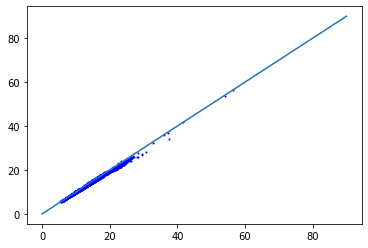

In [167]:
pre = net_1(x_test_tensor)
plt.plot(pre.numpy()[0][::-1].reshape(-1), y_test_resize_tensor.numpy()[0][::-1].reshape(-1),'bo', markersize=1)
plt.plot([0,90],[0,90])

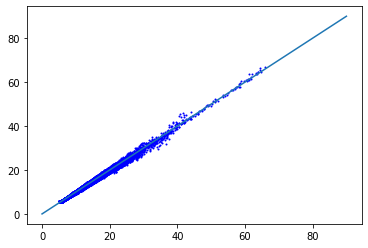

In [168]:
plt.plot(pre.numpy()[::-1].reshape(-1), y_test_resize_tensor.numpy()[::-1].reshape(-1),'bo', markersize=1)
plt.plot([0,90],[0,90])

<AxesSubplot: >

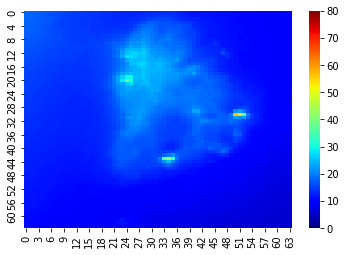

In [171]:
sns.heatmap(pre.numpy()[0,:,:,0][::-1], cmap = 'jet',vmin=0, vmax=80)

<AxesSubplot: >

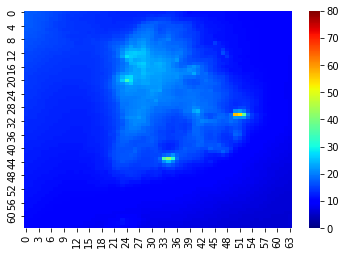

In [172]:
sns.heatmap(y_test_resize_tensor.numpy()[0,:,:,0][::-1], cmap = 'jet',vmin=0, vmax=80)

### 원본 Unet_test1

In [173]:
class CBR2d(tf.keras.layers.Layer):
    def __init__(self, out_channels,kernel_size = 3):
        super(CBR2d, self).__init__()
        self.cnn_layer = tf.keras.layers.Conv2D(out_channels, kernel_size, activation='relu', padding='same')
        self.batch_layer = tf.keras.layers.BatchNormalization()
              
    def call(self, inputs):
        cnn_feat_x = self.cnn_layer(inputs)
        batched_feat = self.batch_layer(cnn_feat_x)
        return batched_feat

class Unet(tf.keras.Model): 
    def __init__(self,): 
        super(Unet, self).__init__()

        self.enc1_1 = CBR2d(out_channels = 64) 
        self.enc1_2 = CBR2d(out_channels=64)
            
        self.pool1 = tf.keras.layers.MaxPool2D(pool_size=(2,2), )
        
        self.enc2_1 = CBR2d(out_channels=128)
        self.enc2_2 = CBR2d(out_channels=128)
        
        self.pool2 = tf.keras.layers.MaxPool2D(pool_size=(2,2), )
        
        self.enc3_1 = CBR2d(out_channels=256)
        self.enc3_2 = CBR2d(out_channels=256)
        self.pool3 = tf.keras.layers.MaxPool2D(pool_size=(2,2), )

        self.enc4_1 = CBR2d(out_channels=512)
        self.enc4_2 = CBR2d(out_channels=512)
        self.pool4 = tf.keras.layers.MaxPool2D(pool_size=(2,2), )
        
        
        self.enc5_1 = CBR2d(out_channels=1024)
        self.dec5_1 = CBR2d(out_channels=512)

        self.unpool4 = tf.keras.layers.Conv2DTranspose(filters=512, kernel_size=2,strides=(2, 2))

        self.dec4_2 = CBR2d(out_channels=512)
        self.dec4_1 = CBR2d(out_channels=256)

        self.unpool3 = tf.keras.layers.Conv2DTranspose(filters=256, kernel_size=2,strides=(2, 2))

        self.dec3_2 = CBR2d(out_channels=256)
        self.dec3_1 = CBR2d(out_channels=128)

        self.unpool2 = tf.keras.layers.Conv2DTranspose(filters=128, kernel_size=2,strides=(2, 2))

        self.dec2_2 = CBR2d(out_channels=128)
        self.dec2_1 = CBR2d(out_channels=64)

        self.unpool1 = tf.keras.layers.Conv2DTranspose(filters=64, kernel_size=2,strides=(2, 2))

        self.dec1_2 = CBR2d(out_channels=64)
        self.dec1_1 = CBR2d(out_channels=64)

        self.outlayer = tf.keras.layers.Conv2D(1,kernel_size = 1)
              
    def call(self, input): 
      
        enc1_1 = self.enc1_1(input)
        enc1_2 = self.enc1_2(enc1_1)
        
        pool1 = self.pool1(enc1_2)

        enc2_1 = self.enc2_1(pool1)
        enc2_2 = self.enc2_2(enc2_1)
        
        pool2= self.pool2(enc2_2)
  
        enc3_1 = self.enc3_1(pool2)
        enc3_2 = self.enc3_2(enc3_1)
        
        pool3= self.pool3(enc3_2)

        enc4_1 = self.enc4_1(pool3)
        enc4_2 = self.enc4_2(enc4_1)
        
        pool4= self.pool3(enc4_2)

        enc5_1 = self.enc5_1(pool4)
        
        dec5_1 = self.dec5_1(enc5_1)
        

        unpool4 = self.unpool4(dec5_1)

        cat4 = tf.keras.layers.Concatenate(axis=3)([unpool4, enc4_2]) # dim = [0:batch, 1:channel, 2:height, 3:width]
        
        dec4_2 = self.dec4_2(cat4)
        dec4_1 = self.dec4_1(dec4_2)
       
        unpool3 = self.unpool3(dec4_1)
    
        cat3 = tf.keras.layers.Concatenate(axis=3)([unpool3, enc3_2]) # dim = [0:batch, 1:channel, 2:height, 3:width]
        dec3_2 = self.dec3_2(cat3)
        dec3_1 = self.dec3_1(dec3_2)
        
        unpool2 = self.unpool2(dec3_1)
        
        cat2 = tf.keras.layers.Concatenate(axis=3)([unpool2, enc2_2]) # dim = [0:batch, 1:channel, 2:height, 3:width]
        dec2_2 = self.dec2_2(cat2)
        dec2_1 = self.dec2_1(dec2_2)
        
        unpool1 = self.unpool1(dec2_1)
        
        cat1 = tf.keras.layers.Concatenate(axis=3)([unpool1, enc1_2]) # dim = [0:batch, 1:channel, 2:height, 3:width]
        dec1_2 = self.dec1_2(cat1)
        dec1_1 = self.dec1_1(dec1_2)
        
        x = self.outlayer(dec1_1)
        return x

In [175]:
x_train_tensor = tf.convert_to_tensor(x_train,dtype = float)
x_test_tensor = tf.convert_to_tensor(x_test,dtype = float)
y_train_resize_tensor = tf.convert_to_tensor(y_train,dtype = float)
y_test_resize_tensor = tf.convert_to_tensor(pm2_5,dtype = float)

batch_size = 20
epoch = 500
buffer_len = len(x_train_tensor)
n_run = np.ceil(len(x_train_tensor)/batch_size)
print(f'배치사이즈: {batch_size}, 에폭당 학습수: {n_run}, 에폭: {epoch}')

train_dataset = tf.data.Dataset.zip((tf.data.Dataset.from_tensor_slices(x_train_tensor), tf.data.Dataset.from_tensor_slices(y_train_resize_tensor),))
shuffled_dataset = train_dataset.shuffle(buffer_size=buffer_len)

net_1 = Unet()
# test_net = Unet()
# pred = test_net(x_train)

배치사이즈: 20, 에폭당 학습수: 4.0, 에폭: 500


In [176]:
@tf.function()
def train_step(input, label, network, loss_fun):
  
  with tf.GradientTape() as tape:
    ##로스 계산
    pred = network(input)
    
    loss = loss_fun(label, pred)
  grads = tape.gradient(loss, network.trainable_variables)
  optimizer.apply_gradients(zip(grads, network.trainable_variables))
  return loss



loss = tf.keras.losses.MeanSquaredError()
optimizer = tf.keras.optimizers.Adam(0.00005)

for epoc in range(epoch):
    count = 0

    for batch in shuffled_dataset.batch(batch_size).take(n_run):

        count += 1
        mse_loss = train_step(batch[0],batch[1], net_1,loss).numpy()
        print(f"batch: {count}/{n_run} ---epoch: {epoc}/{epoch}--- mse-loss: {mse_loss}")

batch: 1/4.0 ---epoch: 0/500--- mse-loss: 177.58505249023438
batch: 2/4.0 ---epoch: 0/500--- mse-loss: 176.72499084472656
batch: 3/4.0 ---epoch: 0/500--- mse-loss: 176.54330444335938
batch: 4/4.0 ---epoch: 0/500--- mse-loss: 177.03536987304688
batch: 1/4.0 ---epoch: 1/500--- mse-loss: 175.648681640625
batch: 2/4.0 ---epoch: 1/500--- mse-loss: 174.81307983398438
batch: 3/4.0 ---epoch: 1/500--- mse-loss: 177.4523468017578
batch: 4/4.0 ---epoch: 1/500--- mse-loss: 175.54119873046875
batch: 1/4.0 ---epoch: 2/500--- mse-loss: 174.540283203125
batch: 2/4.0 ---epoch: 2/500--- mse-loss: 173.2499237060547
batch: 3/4.0 ---epoch: 2/500--- mse-loss: 175.39422607421875
batch: 4/4.0 ---epoch: 2/500--- mse-loss: 171.5496826171875
batch: 1/4.0 ---epoch: 3/500--- mse-loss: 169.91677856445312
batch: 2/4.0 ---epoch: 3/500--- mse-loss: 168.11410522460938
batch: 3/4.0 ---epoch: 3/500--- mse-loss: 163.87013244628906
batch: 4/4.0 ---epoch: 3/500--- mse-loss: 158.6038818359375
batch: 1/4.0 ---epoch: 4/500--- 

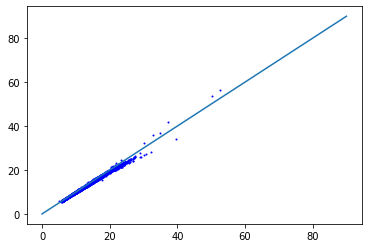

In [177]:
pre = net_1(x_test_tensor)
plt.plot(pre.numpy()[0][::-1].reshape(-1), y_test_resize_tensor.numpy()[0][::-1].reshape(-1),'bo', markersize=1)
plt.plot([0,90],[0,90])

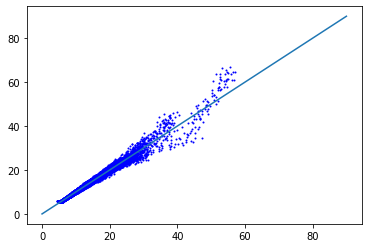

In [178]:
plt.plot(pre.numpy()[::-1].reshape(-1), y_test_resize_tensor.numpy()[::-1].reshape(-1),'bo', markersize=1)
plt.plot([0,90],[0,90])

<AxesSubplot: >

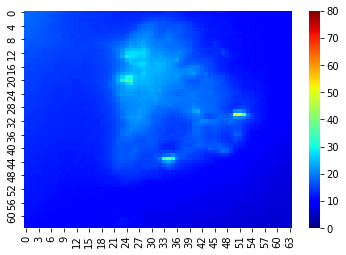

In [179]:
sns.heatmap(pre.numpy()[0,:,:,0][::-1], cmap = 'jet',vmin=0, vmax=80)

<AxesSubplot: >

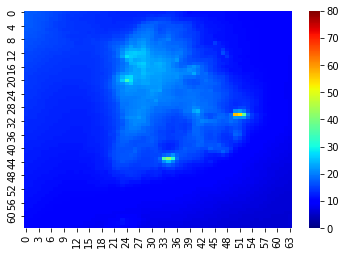

In [180]:
sns.heatmap(y_test_resize_tensor.numpy()[0,:,:,0][::-1], cmap = 'jet',vmin=0, vmax=80)

### 원본 Unet_test2

In [181]:
class CBR2d(tf.keras.layers.Layer):
    def __init__(self, out_channels,kernel_size = 3):
        super(CBR2d, self).__init__()
        self.cnn_layer = tf.keras.layers.Conv2D(out_channels, kernel_size, activation='relu', padding='same')
        self.batch_layer = tf.keras.layers.BatchNormalization()
              
    def call(self, inputs):
        cnn_feat_x = self.cnn_layer(inputs)
        batched_feat = self.batch_layer(cnn_feat_x)
        return batched_feat

class Unet(tf.keras.Model): 
    def __init__(self,): 
        super(Unet, self).__init__()

        self.enc1_1 = CBR2d(out_channels = 64) 
        self.enc1_2 = CBR2d(out_channels=64)
            
        self.pool1 = tf.keras.layers.MaxPool2D(pool_size=(2,2), )
        
        self.enc2_1 = CBR2d(out_channels=128)
        self.enc2_2 = CBR2d(out_channels=128)
        
        self.pool2 = tf.keras.layers.MaxPool2D(pool_size=(2,2), )
        
        self.enc3_1 = CBR2d(out_channels=256)
        self.enc3_2 = CBR2d(out_channels=256)
        self.pool3 = tf.keras.layers.MaxPool2D(pool_size=(2,2), )

        self.enc4_1 = CBR2d(out_channels=512)
        self.enc4_2 = CBR2d(out_channels=512)
        self.pool4 = tf.keras.layers.MaxPool2D(pool_size=(2,2), )
        
        
        self.enc5_1 = CBR2d(out_channels=1024)
        self.dec5_1 = CBR2d(out_channels=512)

        self.unpool4 = tf.keras.layers.Conv2DTranspose(filters=512, kernel_size=2,strides=(2, 2))

        self.dec4_2 = CBR2d(out_channels=512)
        self.dec4_1 = CBR2d(out_channels=256)

        self.unpool3 = tf.keras.layers.Conv2DTranspose(filters=256, kernel_size=2,strides=(2, 2))

        self.dec3_2 = CBR2d(out_channels=256)
        self.dec3_1 = CBR2d(out_channels=128)

        self.unpool2 = tf.keras.layers.Conv2DTranspose(filters=128, kernel_size=2,strides=(2, 2))

        self.dec2_2 = CBR2d(out_channels=128)
        self.dec2_1 = CBR2d(out_channels=64)

        self.unpool1 = tf.keras.layers.Conv2DTranspose(filters=64, kernel_size=2,strides=(2, 2))

        self.dec1_2 = CBR2d(out_channels=64)
        self.dec1_1 = CBR2d(out_channels=64)

        self.outlayer = tf.keras.layers.Conv2D(1,kernel_size = 1)
              
    def call(self, input): 
      
        enc1_1 = self.enc1_1(input)
        enc1_2 = self.enc1_2(enc1_1)
        
        pool1 = self.pool1(enc1_2)

        enc2_1 = self.enc2_1(pool1)
        enc2_2 = self.enc2_2(enc2_1)
        
        pool2= self.pool2(enc2_2)
  
        enc3_1 = self.enc3_1(pool2)
        enc3_2 = self.enc3_2(enc3_1)
        
        pool3= self.pool3(enc3_2)

        enc4_1 = self.enc4_1(pool3)
        enc4_2 = self.enc4_2(enc4_1)
        
        pool4= self.pool3(enc4_2)

        enc5_1 = self.enc5_1(pool4)
        
        dec5_1 = self.dec5_1(enc5_1)
        

        unpool4 = self.unpool4(dec5_1)

        cat4 = tf.keras.layers.Concatenate(axis=3)([unpool4, enc4_2]) # dim = [0:batch, 1:channel, 2:height, 3:width]
        
        dec4_2 = self.dec4_2(cat4)
        dec4_1 = self.dec4_1(dec4_2)
       
        unpool3 = self.unpool3(dec4_1)
    
        cat3 = tf.keras.layers.Concatenate(axis=3)([unpool3, enc3_2]) # dim = [0:batch, 1:channel, 2:height, 3:width]
        dec3_2 = self.dec3_2(cat3)
        dec3_1 = self.dec3_1(dec3_2)
        
        unpool2 = self.unpool2(dec3_1)
        
        cat2 = tf.keras.layers.Concatenate(axis=3)([unpool2, enc2_2]) # dim = [0:batch, 1:channel, 2:height, 3:width]
        dec2_2 = self.dec2_2(cat2)
        dec2_1 = self.dec2_1(dec2_2)
        
        unpool1 = self.unpool1(dec2_1)
        
        cat1 = tf.keras.layers.Concatenate(axis=3)([unpool1, enc1_2]) # dim = [0:batch, 1:channel, 2:height, 3:width]
        dec1_2 = self.dec1_2(cat1)
        dec1_1 = self.dec1_1(dec1_2)
        
        x = self.outlayer(dec1_1)
        return x

In [182]:
x_train_tensor = tf.convert_to_tensor(x_train,dtype = float)
x_test_tensor = tf.convert_to_tensor(x_test,dtype = float)
y_train_resize_tensor = tf.convert_to_tensor(y_train,dtype = float)
y_test_resize_tensor = tf.convert_to_tensor(pm2_5,dtype = float)

batch_size = 20
epoch = 2000
buffer_len = len(x_train_tensor)
n_run = np.ceil(len(x_train_tensor)/batch_size)
print(f'배치사이즈: {batch_size}, 에폭당 학습수: {n_run}, 에폭: {epoch}')

train_dataset = tf.data.Dataset.zip((tf.data.Dataset.from_tensor_slices(x_train_tensor), tf.data.Dataset.from_tensor_slices(y_train_resize_tensor),))
shuffled_dataset = train_dataset.shuffle(buffer_size=buffer_len)

net_1 = Unet()
# test_net = Unet()
# pred = test_net(x_train)

배치사이즈: 20, 에폭당 학습수: 4.0, 에폭: 2000


In [183]:
@tf.function()
def train_step(input, label, network, loss_fun):
  
  with tf.GradientTape() as tape:
    ##로스 계산
    pred = network(input)
    
    loss = loss_fun(label, pred)
  grads = tape.gradient(loss, network.trainable_variables)
  optimizer.apply_gradients(zip(grads, network.trainable_variables))
  return loss



loss = tf.keras.losses.MeanSquaredError()
optimizer = tf.keras.optimizers.Adam(0.00005)

for epoc in range(epoch):
    count = 0

    for batch in shuffled_dataset.batch(batch_size).take(n_run):

        count += 1
        mse_loss = train_step(batch[0],batch[1], net_1,loss).numpy()
        print(f"batch: {count}/{n_run} ---epoch: {epoc}/{epoch}--- mse-loss: {mse_loss}")

batch: 1/4.0 ---epoch: 0/2000--- mse-loss: 177.5019989013672
batch: 2/4.0 ---epoch: 0/2000--- mse-loss: 176.83401489257812
batch: 3/4.0 ---epoch: 0/2000--- mse-loss: 178.70700073242188
batch: 4/4.0 ---epoch: 0/2000--- mse-loss: 176.43785095214844
batch: 1/4.0 ---epoch: 1/2000--- mse-loss: 176.78350830078125
batch: 2/4.0 ---epoch: 1/2000--- mse-loss: 176.9363250732422
batch: 3/4.0 ---epoch: 1/2000--- mse-loss: 177.1997528076172
batch: 4/4.0 ---epoch: 1/2000--- mse-loss: 175.2811737060547
batch: 1/4.0 ---epoch: 2/2000--- mse-loss: 175.00035095214844
batch: 2/4.0 ---epoch: 2/2000--- mse-loss: 175.17349243164062
batch: 3/4.0 ---epoch: 2/2000--- mse-loss: 175.6261749267578
batch: 4/4.0 ---epoch: 2/2000--- mse-loss: 176.522216796875
batch: 1/4.0 ---epoch: 3/2000--- mse-loss: 174.26222229003906
batch: 2/4.0 ---epoch: 3/2000--- mse-loss: 172.2584991455078
batch: 3/4.0 ---epoch: 3/2000--- mse-loss: 169.41549682617188
batch: 4/4.0 ---epoch: 3/2000--- mse-loss: 165.7749786376953
batch: 1/4.0 ---e

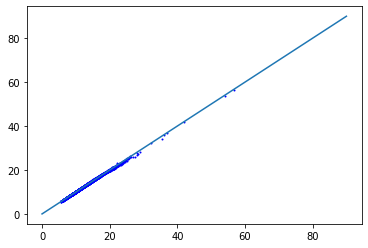

In [184]:
pre = net_1(x_test_tensor)
plt.plot(pre.numpy()[0][::-1].reshape(-1), y_test_resize_tensor.numpy()[0][::-1].reshape(-1),'bo', markersize=1)
plt.plot([0,90],[0,90])

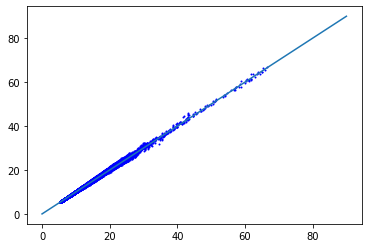

In [185]:
plt.plot(pre.numpy()[::-1].reshape(-1), y_test_resize_tensor.numpy()[::-1].reshape(-1),'bo', markersize=1)
plt.plot([0,90],[0,90])

<AxesSubplot: >

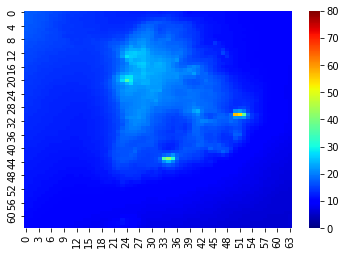

In [188]:
sns.heatmap(pre.numpy()[0,:,:,0][::-1], cmap = 'jet',vmin=0, vmax=80)

<AxesSubplot: >

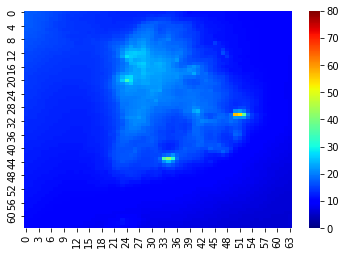

In [189]:
sns.heatmap(y_test_resize_tensor.numpy()[0,:,:,0][::-1], cmap = 'jet',vmin=0, vmax=80)

### 기본 Unet_test_1

In [191]:
OUTPUT_CHANNELS = 1

def downsample(filters, size, apply_batchnorm=True):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
      tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))

  if apply_batchnorm:
    result.add(tf.keras.layers.BatchNormalization())

  result.add(tf.keras.layers.LeakyReLU())

  return result

def upsample(filters, size, apply_dropout=False):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
    tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                    padding='same',
                                    kernel_initializer=initializer,
                                    use_bias=False))

  result.add(tf.keras.layers.BatchNormalization())

  if apply_dropout:
      result.add(tf.keras.layers.Dropout(0.5))

  result.add(tf.keras.layers.ReLU())

  return result

def Unet():
  # data_augmentation = tf.keras.Sequential([
  #   # tf.keras.layers.RandomFlip('horizontal'), # "horizontal", "vertical", or "horizontal_and_vertical"
  #   # tf.keras.layers.RandomRotation(0.2),
  #   tf.keras.layers.GaussianNoise(   # 노이즈레이어 이부분도 학습에서만 활성화됨
  #       1, seed=None,
  #   )
  #   ])




  inputs = tf.keras.layers.Input(shape=[64, 64, 4])

  down_stack = [
    downsample(64, 3),  # (batch_size, 64, 64, 64)
    downsample(128, 3),  # (batch_size, 32, 32, 128)
    downsample(256, 3),  # (batch_size, 16, 16, 256)
    downsample(512, 3),  # (batch_size, 8, 8, 512)
    downsample(512, 3),  # (batch_size, 4, 4, 512)
  ]

  up_stack = [
    upsample(512, 3, apply_dropout=True),  # (batch_size, 4, 4, 1024)
    upsample(512, 3),  # (batch_size, 8, 8, 1024)
    upsample(256, 3),  # (batch_size, 16, 16, 512)
    upsample(128, 3),  # (batch_size, 32, 32, 256)
    upsample(64, 3),  # (batch_size, 64, 64, 128)
  ]

  initializer = tf.random_normal_initializer(0., 0.02)
  last = tf.keras.layers.Conv2DTranspose(OUTPUT_CHANNELS, 2,
                                         strides=2,
                                         padding='same',
                                         kernel_initializer=initializer,
                                         )  # (batch_size, 256, 256, 3)  activation='tanh'

  x = inputs
  # x = data_augmentation(x)      

  # Downsampling through the model
  skips = []
  for down in down_stack:
    x = down(x)
    skips.append(x)

  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    x = tf.keras.layers.Concatenate()([x, skip])

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

In [192]:
x_train_tensor = tf.convert_to_tensor(x_train,dtype = float)
x_test_tensor = tf.convert_to_tensor(x_test,dtype = float)
y_train_resize_tensor = tf.convert_to_tensor(y_train,dtype = float)
y_test_resize_tensor = tf.convert_to_tensor(pm2_5,dtype = float)

batch_size = 20
epoch = 2000
buffer_len = len(x_train_tensor)
n_run = np.ceil(len(x_train_tensor)/batch_size)
print(f'배치사이즈: {batch_size}, 에폭당 학습수: {n_run}, 에폭: {epoch}')

train_dataset = tf.data.Dataset.zip((tf.data.Dataset.from_tensor_slices(x_train_tensor), tf.data.Dataset.from_tensor_slices(y_train_resize_tensor),))
shuffled_dataset = train_dataset.shuffle(buffer_size=buffer_len)

net_1 = Unet()
# test_net = Unet()
# pred = test_net(x_train)

배치사이즈: 20, 에폭당 학습수: 4.0, 에폭: 2000


In [193]:
@tf.function()
def train_step(input, label, network, loss_fun):
  
  with tf.GradientTape() as tape:
    ##로스 계산
    pred = network(input)
    
    loss = loss_fun(label, pred)
  grads = tape.gradient(loss, network.trainable_variables)
  optimizer.apply_gradients(zip(grads, network.trainable_variables))
  return loss



loss = tf.keras.losses.MeanSquaredError()
optimizer = tf.keras.optimizers.Adam(0.0001)

for epoc in range(epoch):
    count = 0

    for batch in shuffled_dataset.batch(batch_size).take(n_run):

        count += 1
        mse_loss = train_step(batch[0],batch[1], net_1,loss).numpy()
        print(f"batch: {count}/{n_run} ---epoch: {epoc}/{epoch}--- mse-loss: {mse_loss}")

batch: 1/4.0 ---epoch: 0/2000--- mse-loss: 176.19406127929688
batch: 2/4.0 ---epoch: 0/2000--- mse-loss: 178.52587890625
batch: 3/4.0 ---epoch: 0/2000--- mse-loss: 178.31851196289062
batch: 4/4.0 ---epoch: 0/2000--- mse-loss: 178.57269287109375
batch: 1/4.0 ---epoch: 1/2000--- mse-loss: 175.88192749023438
batch: 2/4.0 ---epoch: 1/2000--- mse-loss: 177.98263549804688
batch: 3/4.0 ---epoch: 1/2000--- mse-loss: 178.85647583007812
batch: 4/4.0 ---epoch: 1/2000--- mse-loss: 178.6934814453125
batch: 1/4.0 ---epoch: 2/2000--- mse-loss: 176.2321014404297
batch: 2/4.0 ---epoch: 2/2000--- mse-loss: 179.24172973632812
batch: 3/4.0 ---epoch: 2/2000--- mse-loss: 176.98635864257812
batch: 4/4.0 ---epoch: 2/2000--- mse-loss: 178.30136108398438
batch: 1/4.0 ---epoch: 3/2000--- mse-loss: 176.81948852539062
batch: 2/4.0 ---epoch: 3/2000--- mse-loss: 177.75466918945312
batch: 3/4.0 ---epoch: 3/2000--- mse-loss: 177.0218048095703
batch: 4/4.0 ---epoch: 3/2000--- mse-loss: 177.18336486816406
batch: 1/4.0 -

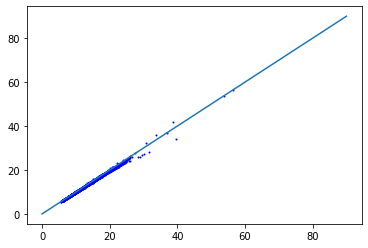

In [194]:
pre = net_1(x_test_tensor)
plt.plot(pre.numpy()[0][::-1].reshape(-1), y_test_resize_tensor.numpy()[0][::-1].reshape(-1),'bo', markersize=1)
plt.plot([0,90],[0,90])


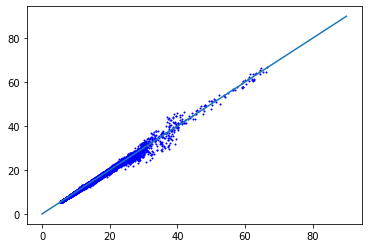

In [195]:
plt.plot(pre.numpy()[::-1].reshape(-1), y_test_resize_tensor.numpy()[::-1].reshape(-1),'bo', markersize=1)
plt.plot([0,90],[0,90])

<AxesSubplot: >

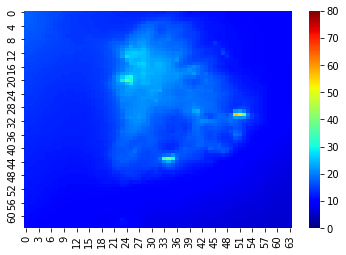

In [196]:
sns.heatmap(pre.numpy()[0,:,:,0][::-1], cmap = 'jet',vmin=0, vmax=80)

<AxesSubplot: >

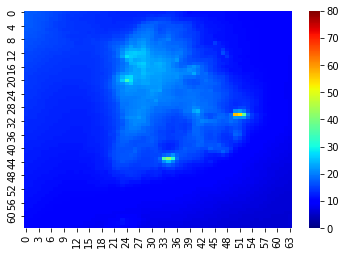

In [197]:
sns.heatmap(y_test_resize_tensor.numpy()[0,:,:,0][::-1], cmap = 'jet',vmin=0, vmax=80)

In [198]:
@tf.function()
def train_step(input, label, network, loss_fun):
  
  with tf.GradientTape() as tape:
    ##로스 계산
    pred = network(input)
    
    loss = loss_fun(label, pred)
  grads = tape.gradient(loss, network.trainable_variables)
  optimizer.apply_gradients(zip(grads, network.trainable_variables))
  return loss



loss = tf.keras.losses.MeanSquaredError()
optimizer = tf.keras.optimizers.Adam(0.00005)

for epoc in range(epoch):
    count = 0

    for batch in shuffled_dataset.batch(batch_size).take(n_run):

        count += 1
        mse_loss = train_step(batch[0],batch[1], net_1,loss).numpy()
        print(f"batch: {count}/{n_run} ---epoch: {epoc}/{epoch}--- mse-loss: {mse_loss}")

batch: 1/4.0 ---epoch: 0/2000--- mse-loss: 0.04504096880555153
batch: 2/4.0 ---epoch: 0/2000--- mse-loss: 3.0967400074005127
batch: 3/4.0 ---epoch: 0/2000--- mse-loss: 0.25289684534072876
batch: 4/4.0 ---epoch: 0/2000--- mse-loss: 0.8073978424072266
batch: 1/4.0 ---epoch: 1/2000--- mse-loss: 1.7710460424423218
batch: 2/4.0 ---epoch: 1/2000--- mse-loss: 0.8470832109451294
batch: 3/4.0 ---epoch: 1/2000--- mse-loss: 0.05974907800555229
batch: 4/4.0 ---epoch: 1/2000--- mse-loss: 0.29960697889328003
batch: 1/4.0 ---epoch: 2/2000--- mse-loss: 0.8363380432128906
batch: 2/4.0 ---epoch: 2/2000--- mse-loss: 0.8964923620223999
batch: 3/4.0 ---epoch: 2/2000--- mse-loss: 0.5395572781562805
batch: 4/4.0 ---epoch: 2/2000--- mse-loss: 0.1135946661233902
batch: 1/4.0 ---epoch: 3/2000--- mse-loss: 0.06991562247276306
batch: 2/4.0 ---epoch: 3/2000--- mse-loss: 0.35970640182495117
batch: 3/4.0 ---epoch: 3/2000--- mse-loss: 0.5244412422180176
batch: 4/4.0 ---epoch: 3/2000--- mse-loss: 0.4163796007633209
ba

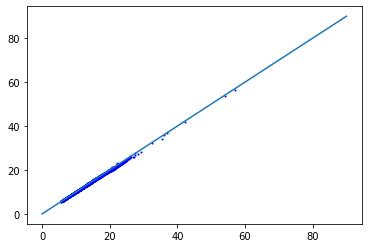

In [199]:
pre = net_1(x_test_tensor)
plt.plot(pre.numpy()[0][::-1].reshape(-1), y_test_resize_tensor.numpy()[0][::-1].reshape(-1),'bo', markersize=1)
plt.plot([0,90],[0,90])


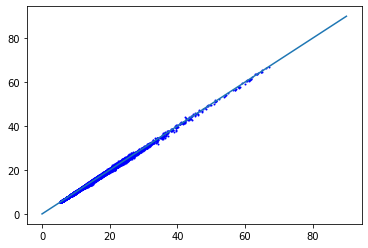

In [200]:
plt.plot(pre.numpy()[::-1].reshape(-1), y_test_resize_tensor.numpy()[::-1].reshape(-1),'bo', markersize=1)
plt.plot([0,90],[0,90])

<AxesSubplot: >

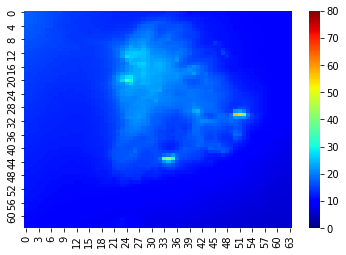

In [201]:
sns.heatmap(pre.numpy()[0,:,:,0][::-1], cmap = 'jet',vmin=0, vmax=80)

<AxesSubplot: >

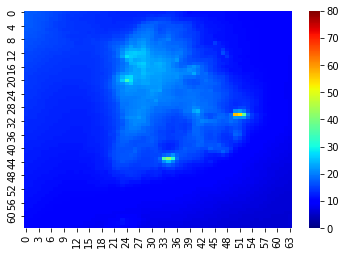

In [202]:
sns.heatmap(y_test_resize_tensor.numpy()[0,:,:,0][::-1], cmap = 'jet',vmin=0, vmax=80)

In [203]:
@tf.function()
def train_step(input, label, network, loss_fun):
  
  with tf.GradientTape() as tape:
    ##로스 계산
    pred = network(input)
    
    loss = loss_fun(label, pred)
  grads = tape.gradient(loss, network.trainable_variables)
  optimizer.apply_gradients(zip(grads, network.trainable_variables))
  return loss



loss = tf.keras.losses.MeanSquaredError()
optimizer = tf.keras.optimizers.Adam(0.00001)

for epoc in range(epoch):
    count = 0

    for batch in shuffled_dataset.batch(batch_size).take(n_run):

        count += 1
        mse_loss = train_step(batch[0],batch[1], net_1,loss).numpy()
        print(f"batch: {count}/{n_run} ---epoch: {epoc}/{epoch}--- mse-loss: {mse_loss}")

batch: 1/4.0 ---epoch: 0/2000--- mse-loss: 0.009649338200688362
batch: 2/4.0 ---epoch: 0/2000--- mse-loss: 0.10683967173099518
batch: 3/4.0 ---epoch: 0/2000--- mse-loss: 0.011824545450508595
batch: 4/4.0 ---epoch: 0/2000--- mse-loss: 0.05290982872247696
batch: 1/4.0 ---epoch: 1/2000--- mse-loss: 0.07201985269784927
batch: 2/4.0 ---epoch: 1/2000--- mse-loss: 0.03788567706942558
batch: 3/4.0 ---epoch: 1/2000--- mse-loss: 0.010633712634444237
batch: 4/4.0 ---epoch: 1/2000--- mse-loss: 0.02118995413184166
batch: 1/4.0 ---epoch: 2/2000--- mse-loss: 0.04395401477813721
batch: 2/4.0 ---epoch: 2/2000--- mse-loss: 0.04439058527350426
batch: 3/4.0 ---epoch: 2/2000--- mse-loss: 0.02250237762928009
batch: 4/4.0 ---epoch: 2/2000--- mse-loss: 0.012428315356373787
batch: 1/4.0 ---epoch: 3/2000--- mse-loss: 0.013729867525398731
batch: 2/4.0 ---epoch: 3/2000--- mse-loss: 0.02444632351398468
batch: 3/4.0 ---epoch: 3/2000--- mse-loss: 0.02840942144393921
batch: 4/4.0 ---epoch: 3/2000--- mse-loss: 0.02496

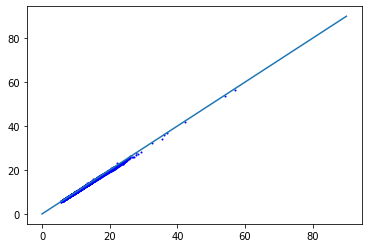

In [208]:
pre = net_1(x_test_tensor)
plt.plot(pre.numpy()[0][::-1].reshape(-1), y_test_resize_tensor.numpy()[0][::-1].reshape(-1),'bo', markersize=1)
plt.plot([0,90],[0,90])


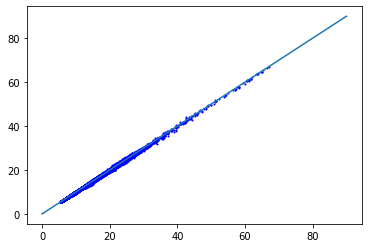

In [209]:
plt.plot(pre.numpy()[::-1].reshape(-1), y_test_resize_tensor.numpy()[::-1].reshape(-1),'bo', markersize=1)
plt.plot([0,90],[0,90])

<AxesSubplot: >

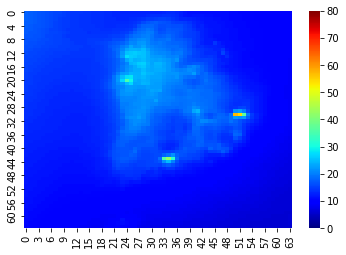

In [210]:
sns.heatmap(pre.numpy()[0,:,:,0][::-1], cmap = 'jet',vmin=0, vmax=80)

<AxesSubplot: >

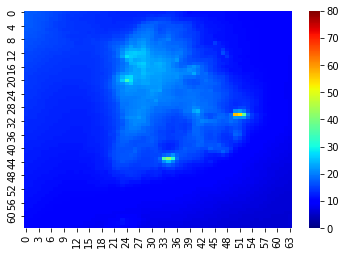

In [211]:
sns.heatmap(y_test_resize_tensor.numpy()[0,:,:,0][::-1], cmap = 'jet',vmin=0, vmax=80)

### 기본 cnn_test1

In [212]:
OUTPUT_CHANNELS = 1

def cnnlayer(filters, size, apply_batchnorm=True):
  # initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  # 이부분은 사이즈 안변하는 연산
  result.add(
      tf.keras.layers.Conv2D(filters, kernel_size = size, padding='same', use_bias=True))

  if apply_batchnorm:
    result.add(tf.keras.layers.BatchNormalization())

  result.add(tf.keras.layers.LeakyReLU())


  return result

def Simple_cnn():
  inputs = tf.keras.layers.Input(shape=[64, 64, 4])

  stack = [
    cnnlayer(64, 3),  # (batch_size, 64, 64, 64)
    cnnlayer(128, 3),  # (batch_size, 32, 32, 128)
    cnnlayer(256, 3),  # (batch_size, 16, 16, 256)
    cnnlayer(512, 3),  # (batch_size, 8, 8, 512)
    cnnlayer(256, 3),  # (batch_size, 8, 8, 512)
    cnnlayer(64, 3),  # (batch_size, 8, 8, 512)
    # downsample(512, 3),  # (batch_size, 4, 4, 512)
  ]
  last = tf.keras.layers.Conv2D(1, 2, padding='same', use_bias=True)

 

  x = inputs
  for layer in stack:
    x = layer(x)
  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

In [213]:
x_train_tensor = tf.convert_to_tensor(x_train,dtype = float)
x_test_tensor = tf.convert_to_tensor(x_test,dtype = float)
y_train_resize_tensor = tf.convert_to_tensor(y_train,dtype = float)
y_test_resize_tensor = tf.convert_to_tensor(pm2_5,dtype = float)

batch_size = 20
epoch = 1000
buffer_len = len(x_train_tensor)
n_run = np.ceil(len(x_train_tensor)/batch_size)
print(f'배치사이즈: {batch_size}, 에폭당 학습수: {n_run}, 에폭: {epoch}')

train_dataset = tf.data.Dataset.zip((tf.data.Dataset.from_tensor_slices(x_train_tensor), tf.data.Dataset.from_tensor_slices(y_train_resize_tensor),))
shuffled_dataset = train_dataset.shuffle(buffer_size=buffer_len)

net_1 = Simple_cnn()
# test_net = Unet()
# pred = test_net(x_train)

배치사이즈: 20, 에폭당 학습수: 4.0, 에폭: 1000


In [214]:
@tf.function()
def train_step(input, label, network, loss_fun):
  
  with tf.GradientTape() as tape:
    ##로스 계산
    pred = network(input)
    
    loss = loss_fun(label, pred)
  grads = tape.gradient(loss, network.trainable_variables)
  optimizer.apply_gradients(zip(grads, network.trainable_variables))
  return loss



loss = tf.keras.losses.MeanSquaredError()
optimizer = tf.keras.optimizers.Adam(0.00005)

for epoc in range(epoch):
    count = 0

    for batch in shuffled_dataset.batch(batch_size).take(n_run):

        count += 1
        mse_loss = train_step(batch[0],batch[1], net_1,loss).numpy()
        print(f"batch: {count}/{n_run} ---epoch: {epoc}/{epoch}--- mse-loss: {mse_loss}")

batch: 1/4.0 ---epoch: 0/1000--- mse-loss: 177.30355834960938
batch: 2/4.0 ---epoch: 0/1000--- mse-loss: 177.16647338867188
batch: 3/4.0 ---epoch: 0/1000--- mse-loss: 175.2029266357422
batch: 4/4.0 ---epoch: 0/1000--- mse-loss: 173.18511962890625
batch: 1/4.0 ---epoch: 1/1000--- mse-loss: 171.24842834472656
batch: 2/4.0 ---epoch: 1/1000--- mse-loss: 169.2606658935547
batch: 3/4.0 ---epoch: 1/1000--- mse-loss: 166.01321411132812
batch: 4/4.0 ---epoch: 1/1000--- mse-loss: 164.3222198486328
batch: 1/4.0 ---epoch: 2/1000--- mse-loss: 159.80885314941406
batch: 2/4.0 ---epoch: 2/1000--- mse-loss: 155.27188110351562
batch: 3/4.0 ---epoch: 2/1000--- mse-loss: 151.56289672851562
batch: 4/4.0 ---epoch: 2/1000--- mse-loss: 147.4778594970703
batch: 1/4.0 ---epoch: 3/1000--- mse-loss: 139.6768798828125
batch: 2/4.0 ---epoch: 3/1000--- mse-loss: 133.53121948242188
batch: 3/4.0 ---epoch: 3/1000--- mse-loss: 126.433837890625
batch: 4/4.0 ---epoch: 3/1000--- mse-loss: 120.18033599853516
batch: 1/4.0 --

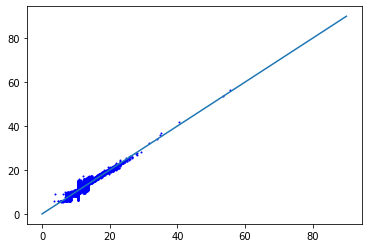

In [215]:
pre = net_1(x_test_tensor)
plt.plot(pre.numpy()[0][::-1].reshape(-1), y_test_resize_tensor.numpy()[0][::-1].reshape(-1),'bo', markersize=1)
plt.plot([0,90],[0,90])

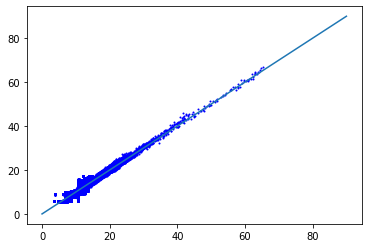

In [216]:
plt.plot(pre.numpy()[::-1].reshape(-1), y_test_resize_tensor.numpy()[::-1].reshape(-1),'bo', markersize=1)
plt.plot([0,90],[0,90])

<AxesSubplot: >

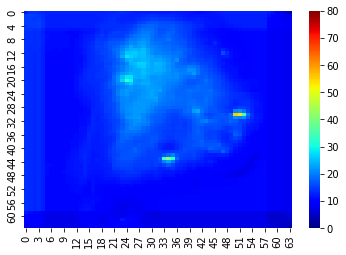

In [217]:
sns.heatmap(pre.numpy()[0,:,:,0][::-1], cmap = 'jet',vmin=0, vmax=80)

<AxesSubplot: >

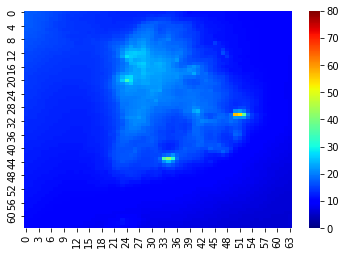

In [218]:
sns.heatmap(y_test_resize_tensor.numpy()[0,:,:,0][::-1], cmap = 'jet',vmin=0, vmax=80)

In [219]:
@tf.function()
def train_step(input, label, network, loss_fun):
  
  with tf.GradientTape() as tape:
    ##로스 계산
    pred = network(input)
    
    loss = loss_fun(label, pred)
  grads = tape.gradient(loss, network.trainable_variables)
  optimizer.apply_gradients(zip(grads, network.trainable_variables))
  return loss



loss = tf.keras.losses.MeanSquaredError()
optimizer = tf.keras.optimizers.Adam(0.00001)

for epoc in range(epoch):
    count = 0

    for batch in shuffled_dataset.batch(batch_size).take(n_run):

        count += 1
        mse_loss = train_step(batch[0],batch[1], net_1,loss).numpy()
        print(f"batch: {count}/{n_run} ---epoch: {epoc}/{epoch}--- mse-loss: {mse_loss}")

batch: 1/4.0 ---epoch: 0/1000--- mse-loss: 1.794980764389038
batch: 2/4.0 ---epoch: 0/1000--- mse-loss: 2.4868736267089844
batch: 3/4.0 ---epoch: 0/1000--- mse-loss: 1.8340904712677002
batch: 4/4.0 ---epoch: 0/1000--- mse-loss: 1.9597866535186768
batch: 1/4.0 ---epoch: 1/1000--- mse-loss: 2.112342357635498
batch: 2/4.0 ---epoch: 1/1000--- mse-loss: 2.0289969444274902
batch: 3/4.0 ---epoch: 1/1000--- mse-loss: 1.7985702753067017
batch: 4/4.0 ---epoch: 1/1000--- mse-loss: 1.8066028356552124
batch: 1/4.0 ---epoch: 2/1000--- mse-loss: 1.9463138580322266
batch: 2/4.0 ---epoch: 2/1000--- mse-loss: 1.9405170679092407
batch: 3/4.0 ---epoch: 2/1000--- mse-loss: 1.8658535480499268
batch: 4/4.0 ---epoch: 2/1000--- mse-loss: 1.823420763015747
batch: 1/4.0 ---epoch: 3/1000--- mse-loss: 1.799433946609497
batch: 2/4.0 ---epoch: 3/1000--- mse-loss: 1.8928844928741455
batch: 3/4.0 ---epoch: 3/1000--- mse-loss: 1.8906056880950928
batch: 4/4.0 ---epoch: 3/1000--- mse-loss: 1.847092866897583
batch: 1/4.0 

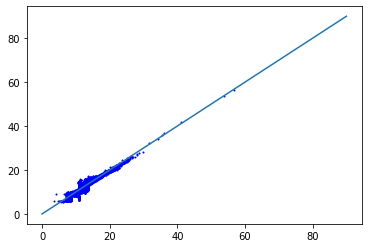

In [220]:
pre = net_1(x_test_tensor)
plt.plot(pre.numpy()[0][::-1].reshape(-1), y_test_resize_tensor.numpy()[0][::-1].reshape(-1),'bo', markersize=1)
plt.plot([0,90],[0,90])

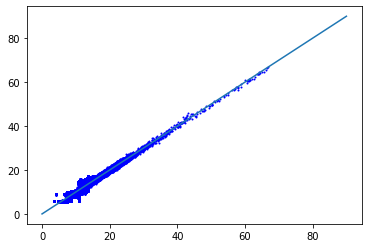

In [221]:
plt.plot(pre.numpy()[::-1].reshape(-1), y_test_resize_tensor.numpy()[::-1].reshape(-1),'bo', markersize=1)
plt.plot([0,90],[0,90])

<AxesSubplot: >

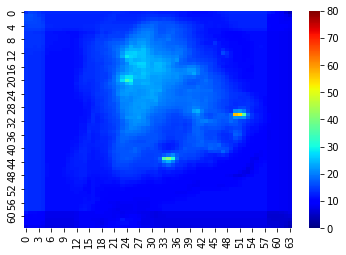

In [222]:
sns.heatmap(pre.numpy()[0,:,:,0][::-1], cmap = 'jet',vmin=0, vmax=80)

<AxesSubplot: >

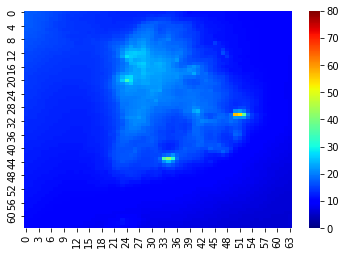

In [223]:
sns.heatmap(y_test_resize_tensor.numpy()[0,:,:,0][::-1], cmap = 'jet',vmin=0, vmax=80)

### 기본 dnn

In [240]:
class Simplednn(tf.keras.Model): 
    def __init__(self,): 
        super(Simplednn, self).__init__()
        self.layer_1 = tf.keras.layers.Dense(128, activation='relu')
        self.batch_layer_1 = tf.keras.layers.BatchNormalization()
        self.layer_2 = tf.keras.layers.Dense(256, activation='relu')
        self.batch_layer_2 = tf.keras.layers.BatchNormalization()
        self.layer_3 = tf.keras.layers.Dense(512, activation='relu')
        self.batch_layer_3 = tf.keras.layers.BatchNormalization()
        self.layer_4 = tf.keras.layers.Dense(1024, activation='relu')
        self.batch_layer_4 = tf.keras.layers.BatchNormalization()
        self.layer_4 = tf.keras.layers.Dense(2048, activation='relu')
        self.batch_layer_4 = tf.keras.layers.BatchNormalization()
        self.layer_4 = tf.keras.layers.Dense(1024, activation='relu')
        self.batch_layer_4 = tf.keras.layers.BatchNormalization()
        self.layer_4 = tf.keras.layers.Dense(1024, activation='relu')
        self.batch_layer_4 = tf.keras.layers.BatchNormalization()
        self.layer_4 = tf.keras.layers.Dense(1024, activation='relu')
        self.batch_layer_4 = tf.keras.layers.BatchNormalization()
        self.layer_5 = tf.keras.layers.Dense(128, activation='relu')
        self.batch_layer_5 = tf.keras.layers.BatchNormalization()
        self.out_layer = tf.keras.layers.Dense(64*64)

    def call(self, input): 

        x = self.layer_1(input)
        x = self.batch_layer_1(x)
        x = self.layer_2(x)
        x = self.batch_layer_2(x)
        x = self.layer_3(x)
        x = self.batch_layer_3(x)
        x = self.layer_4(x)
        x = self.batch_layer_4(x)
        x = self.layer_5(x)
        x = self.batch_layer_5(x)

        x = self.out_layer(x)
        return x

In [241]:
x_train_tensor = tf.reshape(tf.convert_to_tensor(x_train,dtype = float),[len(x_train),-1])
x_test_tensor = tf.reshape(tf.convert_to_tensor(x_test,dtype = float),[len(x_test),-1])
y_train_resize_tensor = tf.reshape(tf.convert_to_tensor(y_train,dtype = float),[len(y_train),-1])
y_test_resize_tensor = tf.reshape(tf.convert_to_tensor(pm2_5,dtype = float),[len(pm2_5),-1])

batch_size = 20
epoch = 1000
buffer_len = len(x_train_tensor)
n_run = np.ceil(len(x_train_tensor)/batch_size)
print(f'배치사이즈: {batch_size}, 에폭당 학습수: {n_run}, 에폭: {epoch}')

train_dataset = tf.data.Dataset.zip((tf.data.Dataset.from_tensor_slices(x_train_tensor), tf.data.Dataset.from_tensor_slices(y_train_resize_tensor),))
shuffled_dataset = train_dataset.shuffle(buffer_size=buffer_len)

net_1 = Simplednn()
# test_net = Unet()
# pred = test_net(x_train)

배치사이즈: 20, 에폭당 학습수: 4.0, 에폭: 1000


In [242]:
x_train_tensor.shape, x_test_tensor.shape, y_train_resize_tensor.shape, y_test_resize_tensor.shape, 

(TensorShape([70, 16384]),
 TensorShape([49, 16384]),
 TensorShape([70, 4096]),
 TensorShape([49, 4096]))

In [243]:
@tf.function()
def train_step(input, label, network, loss_fun):
  
  with tf.GradientTape() as tape:
    ##로스 계산
    pred = network(input)
    
    loss = loss_fun(label, pred)
  grads = tape.gradient(loss, network.trainable_variables)
  optimizer.apply_gradients(zip(grads, network.trainable_variables))
  return loss



loss = tf.keras.losses.MeanSquaredError()
optimizer = tf.keras.optimizers.Adam(0.00005)

for epoc in range(epoch):
    count = 0

    for batch in shuffled_dataset.batch(batch_size).take(n_run):

        count += 1
        mse_loss = train_step(batch[0],batch[1], net_1,loss).numpy()
        print(f"batch: {count}/{n_run} ---epoch: {epoc}/{epoch}--- mse-loss: {mse_loss}")

batch: 1/4.0 ---epoch: 0/1000--- mse-loss: 176.8017120361328
batch: 2/4.0 ---epoch: 0/1000--- mse-loss: 177.43203735351562
batch: 3/4.0 ---epoch: 0/1000--- mse-loss: 178.37356567382812
batch: 4/4.0 ---epoch: 0/1000--- mse-loss: 179.68850708007812
batch: 1/4.0 ---epoch: 1/1000--- mse-loss: 177.71841430664062
batch: 2/4.0 ---epoch: 1/1000--- mse-loss: 177.12942504882812
batch: 3/4.0 ---epoch: 1/1000--- mse-loss: 178.67901611328125
batch: 4/4.0 ---epoch: 1/1000--- mse-loss: 177.13638305664062
batch: 1/4.0 ---epoch: 2/1000--- mse-loss: 177.5498809814453
batch: 2/4.0 ---epoch: 2/1000--- mse-loss: 177.5099639892578
batch: 3/4.0 ---epoch: 2/1000--- mse-loss: 176.85769653320312
batch: 4/4.0 ---epoch: 2/1000--- mse-loss: 178.97804260253906
batch: 1/4.0 ---epoch: 3/1000--- mse-loss: 177.0539093017578
batch: 2/4.0 ---epoch: 3/1000--- mse-loss: 176.41322326660156
batch: 3/4.0 ---epoch: 3/1000--- mse-loss: 177.19869995117188
batch: 4/4.0 ---epoch: 3/1000--- mse-loss: 178.91285705566406
batch: 1/4.0

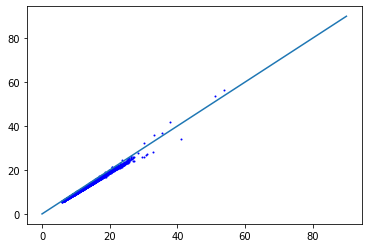

In [244]:
pre = net_1(x_test_tensor)
plt.plot(pre.numpy()[0][::-1].reshape(-1), y_test_resize_tensor.numpy()[0][::-1].reshape(-1),'bo', markersize=1)
plt.plot([0,90],[0,90])


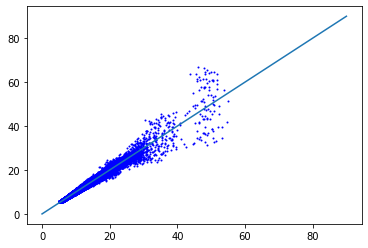

In [245]:
plt.plot(pre.numpy()[::-1].reshape(-1), y_test_resize_tensor.numpy()[::-1].reshape(-1),'bo', markersize=1)
plt.plot([0,90],[0,90])

<AxesSubplot: >

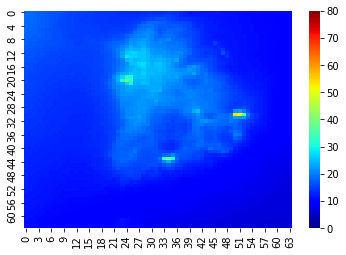

In [246]:
sns.heatmap(pre.numpy().reshape(-1,64,64)[0][::-1], cmap = 'jet',vmin=0, vmax=80)

<AxesSubplot: >

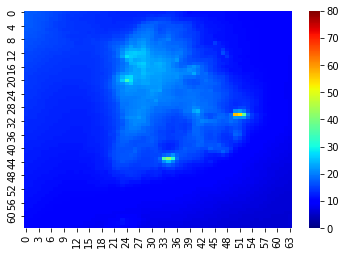

In [247]:
sns.heatmap(y_test_resize_tensor.numpy().reshape(-1,64,64)[0][::-1], cmap = 'jet',vmin=0, vmax=80)

In [248]:
@tf.function()
def train_step(input, label, network, loss_fun):
  
  with tf.GradientTape() as tape:
    ##로스 계산
    pred = network(input)
    
    loss = loss_fun(label, pred)
  grads = tape.gradient(loss, network.trainable_variables)
  optimizer.apply_gradients(zip(grads, network.trainable_variables))
  return loss



loss = tf.keras.losses.MeanSquaredError()
optimizer = tf.keras.optimizers.Adam(0.00001)

for epoc in range(epoch):
    count = 0

    for batch in shuffled_dataset.batch(batch_size).take(n_run):

        count += 1
        mse_loss = train_step(batch[0],batch[1], net_1,loss).numpy()
        print(f"batch: {count}/{n_run} ---epoch: {epoc}/{epoch}--- mse-loss: {mse_loss}")

batch: 1/4.0 ---epoch: 0/1000--- mse-loss: 0.22463616728782654
batch: 2/4.0 ---epoch: 0/1000--- mse-loss: 0.1686427742242813
batch: 3/4.0 ---epoch: 0/1000--- mse-loss: 0.19762089848518372
batch: 4/4.0 ---epoch: 0/1000--- mse-loss: 0.24164395034313202
batch: 1/4.0 ---epoch: 1/1000--- mse-loss: 0.23678846657276154
batch: 2/4.0 ---epoch: 1/1000--- mse-loss: 0.1888635754585266
batch: 3/4.0 ---epoch: 1/1000--- mse-loss: 0.16960251331329346
batch: 4/4.0 ---epoch: 1/1000--- mse-loss: 0.22523872554302216
batch: 1/4.0 ---epoch: 2/1000--- mse-loss: 0.21753565967082977
batch: 2/4.0 ---epoch: 2/1000--- mse-loss: 0.16203096508979797
batch: 3/4.0 ---epoch: 2/1000--- mse-loss: 0.24206824600696564
batch: 4/4.0 ---epoch: 2/1000--- mse-loss: 0.14833620190620422
batch: 1/4.0 ---epoch: 3/1000--- mse-loss: 0.1811572015285492
batch: 2/4.0 ---epoch: 3/1000--- mse-loss: 0.18527016043663025
batch: 3/4.0 ---epoch: 3/1000--- mse-loss: 0.22775721549987793
batch: 4/4.0 ---epoch: 3/1000--- mse-loss: 0.2078082114458

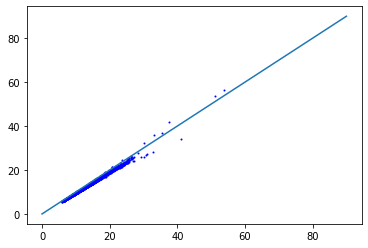

In [249]:
pre = net_1(x_test_tensor)
plt.plot(pre.numpy()[0][::-1].reshape(-1), y_test_resize_tensor.numpy()[0][::-1].reshape(-1),'bo', markersize=1)
plt.plot([0,90],[0,90])


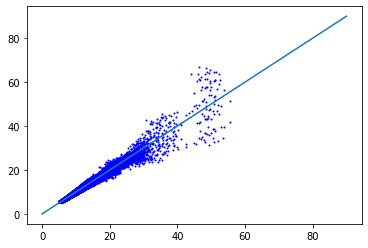

In [250]:
plt.plot(pre.numpy()[::-1].reshape(-1), y_test_resize_tensor.numpy()[::-1].reshape(-1),'bo', markersize=1)
plt.plot([0,90],[0,90])

<AxesSubplot: >

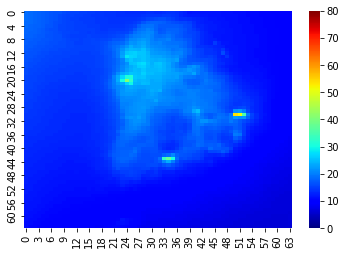

In [251]:
sns.heatmap(pre.numpy().reshape(-1,64,64)[0][::-1], cmap = 'jet',vmin=0, vmax=80)

<AxesSubplot: >

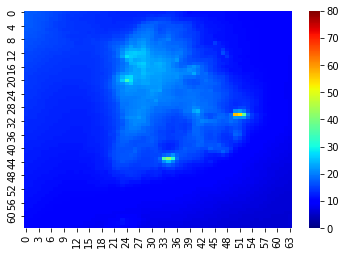

In [252]:
sns.heatmap(y_test_resize_tensor.numpy().reshape(-1,64,64)[0][::-1], cmap = 'jet',vmin=0, vmax=80)

In [253]:
@tf.function()
def train_step(input, label, network, loss_fun):
  
  with tf.GradientTape() as tape:
    ##로스 계산
    pred = network(input)
    
    loss = loss_fun(label, pred)
  grads = tape.gradient(loss, network.trainable_variables)
  optimizer.apply_gradients(zip(grads, network.trainable_variables))
  return loss



loss = tf.keras.losses.MeanSquaredError()
optimizer = tf.keras.optimizers.Adam(0.000001)

for epoc in range(epoch):
    count = 0

    for batch in shuffled_dataset.batch(batch_size).take(n_run):

        count += 1
        mse_loss = train_step(batch[0],batch[1], net_1,loss).numpy()
        print(f"batch: {count}/{n_run} ---epoch: {epoc}/{epoch}--- mse-loss: {mse_loss}")

batch: 1/4.0 ---epoch: 0/1000--- mse-loss: 0.16136114299297333
batch: 2/4.0 ---epoch: 0/1000--- mse-loss: 0.1884877234697342
batch: 3/4.0 ---epoch: 0/1000--- mse-loss: 0.1831609606742859
batch: 4/4.0 ---epoch: 0/1000--- mse-loss: 0.2133735716342926
batch: 1/4.0 ---epoch: 1/1000--- mse-loss: 0.1896481215953827
batch: 2/4.0 ---epoch: 1/1000--- mse-loss: 0.18787625432014465
batch: 3/4.0 ---epoch: 1/1000--- mse-loss: 0.16249361634254456
batch: 4/4.0 ---epoch: 1/1000--- mse-loss: 0.18940989673137665
batch: 1/4.0 ---epoch: 2/1000--- mse-loss: 0.1872830092906952
batch: 2/4.0 ---epoch: 2/1000--- mse-loss: 0.1832827627658844
batch: 3/4.0 ---epoch: 2/1000--- mse-loss: 0.1880124807357788
batch: 4/4.0 ---epoch: 2/1000--- mse-loss: 0.15141335129737854
batch: 1/4.0 ---epoch: 3/1000--- mse-loss: 0.19998423755168915
batch: 2/4.0 ---epoch: 3/1000--- mse-loss: 0.19294504821300507
batch: 3/4.0 ---epoch: 3/1000--- mse-loss: 0.14977458119392395
batch: 4/4.0 ---epoch: 3/1000--- mse-loss: 0.1834043264389038


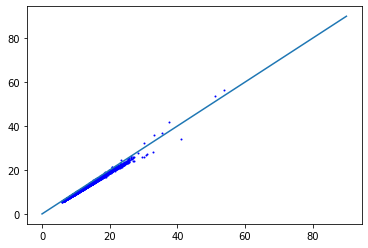

In [254]:
pre = net_1(x_test_tensor)
plt.plot(pre.numpy()[0][::-1].reshape(-1), y_test_resize_tensor.numpy()[0][::-1].reshape(-1),'bo', markersize=1)
plt.plot([0,90],[0,90])


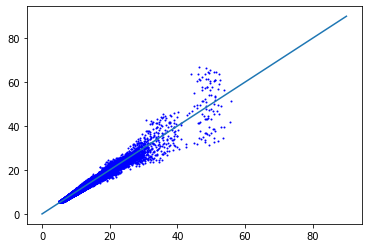

In [255]:
plt.plot(pre.numpy()[::-1].reshape(-1), y_test_resize_tensor.numpy()[::-1].reshape(-1),'bo', markersize=1)
plt.plot([0,90],[0,90])

<AxesSubplot: >

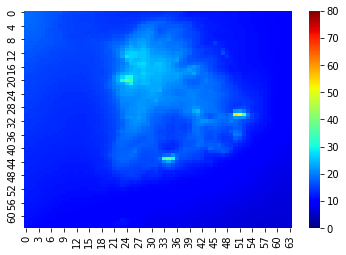

In [256]:
sns.heatmap(pre.numpy().reshape(-1,64,64)[0][::-1], cmap = 'jet',vmin=0, vmax=80)

<AxesSubplot: >

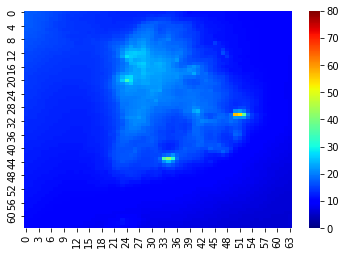

In [257]:
sns.heatmap(y_test_resize_tensor.numpy().reshape(-1,64,64)[0][::-1], cmap = 'jet',vmin=0, vmax=80)

In [258]:
@tf.function()
def train_step(input, label, network, loss_fun):
  
  with tf.GradientTape() as tape:
    ##로스 계산
    pred = network(input)
    
    loss = loss_fun(label, pred)
  grads = tape.gradient(loss, network.trainable_variables)
  optimizer.apply_gradients(zip(grads, network.trainable_variables))
  return loss



loss = tf.keras.losses.MeanSquaredError()
optimizer = tf.keras.optimizers.Adam(0.00005/10)

for epoc in range(epoch):
    count = 0

    for batch in shuffled_dataset.batch(batch_size).take(n_run):

        count += 1
        mse_loss = train_step(batch[0],batch[1], net_1,loss).numpy()
        print(f"batch: {count}/{n_run} ---epoch: {epoc}/{epoch}--- mse-loss: {mse_loss}")

batch: 1/4.0 ---epoch: 0/1000--- mse-loss: 0.1585410088300705
batch: 2/4.0 ---epoch: 0/1000--- mse-loss: 0.19242870807647705
batch: 3/4.0 ---epoch: 0/1000--- mse-loss: 0.17165231704711914
batch: 4/4.0 ---epoch: 0/1000--- mse-loss: 0.21658584475517273
batch: 1/4.0 ---epoch: 1/1000--- mse-loss: 0.1766124963760376
batch: 2/4.0 ---epoch: 1/1000--- mse-loss: 0.1846257746219635
batch: 3/4.0 ---epoch: 1/1000--- mse-loss: 0.21593837440013885
batch: 4/4.0 ---epoch: 1/1000--- mse-loss: 0.11899077892303467
batch: 1/4.0 ---epoch: 2/1000--- mse-loss: 0.20894189178943634
batch: 2/4.0 ---epoch: 2/1000--- mse-loss: 0.15456263720989227
batch: 3/4.0 ---epoch: 2/1000--- mse-loss: 0.1817415952682495
batch: 4/4.0 ---epoch: 2/1000--- mse-loss: 0.1645747870206833
batch: 1/4.0 ---epoch: 3/1000--- mse-loss: 0.19610223174095154
batch: 2/4.0 ---epoch: 3/1000--- mse-loss: 0.19613687694072723
batch: 3/4.0 ---epoch: 3/1000--- mse-loss: 0.16367997229099274
batch: 4/4.0 ---epoch: 3/1000--- mse-loss: 0.146481677889823

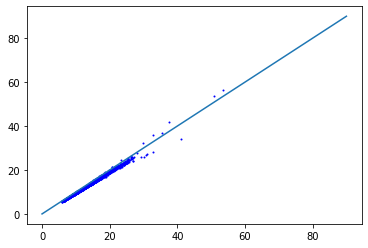

In [259]:
pre = net_1(x_test_tensor)
plt.plot(pre.numpy()[0][::-1].reshape(-1), y_test_resize_tensor.numpy()[0][::-1].reshape(-1),'bo', markersize=1)
plt.plot([0,90],[0,90])


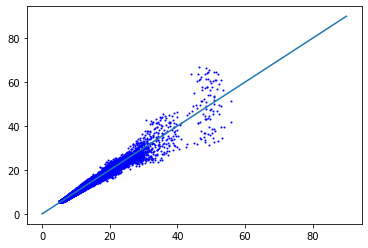

In [260]:
plt.plot(pre.numpy()[::-1].reshape(-1), y_test_resize_tensor.numpy()[::-1].reshape(-1),'bo', markersize=1)
plt.plot([0,90],[0,90])

<AxesSubplot: >

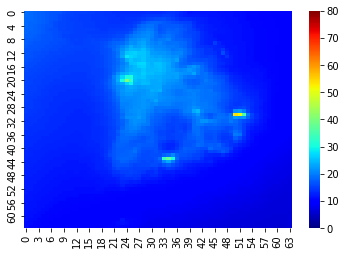

In [261]:
sns.heatmap(pre.numpy().reshape(-1,64,64)[0][::-1], cmap = 'jet',vmin=0, vmax=80)

<AxesSubplot: >

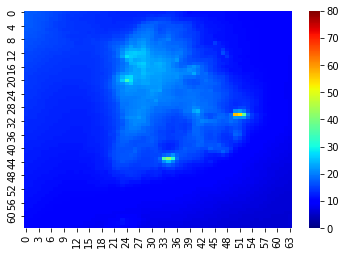

In [262]:
sns.heatmap(y_test_resize_tensor.numpy().reshape(-1,64,64)[0][::-1], cmap = 'jet',vmin=0, vmax=80)

In [263]:
@tf.function()
def train_step(input, label, network, loss_fun):
  
  with tf.GradientTape() as tape:
    ##로스 계산
    pred = network(input)
    
    loss = loss_fun(label, pred)
  grads = tape.gradient(loss, network.trainable_variables)
  optimizer.apply_gradients(zip(grads, network.trainable_variables))
  return loss



loss = tf.keras.losses.MeanSquaredError()
optimizer = tf.keras.optimizers.Adam(0.00005/100)

for epoc in range(epoch):
    count = 0

    for batch in shuffled_dataset.batch(batch_size).take(n_run):

        count += 1
        mse_loss = train_step(batch[0],batch[1], net_1,loss).numpy()
        print(f"batch: {count}/{n_run} ---epoch: {epoc}/{epoch}--- mse-loss: {mse_loss}")

batch: 1/4.0 ---epoch: 0/1000--- mse-loss: 0.16751636564731598
batch: 2/4.0 ---epoch: 0/1000--- mse-loss: 0.17468734085559845
batch: 3/4.0 ---epoch: 0/1000--- mse-loss: 0.1615036129951477
batch: 4/4.0 ---epoch: 0/1000--- mse-loss: 0.19644944369792938
batch: 1/4.0 ---epoch: 1/1000--- mse-loss: 0.1872309148311615
batch: 2/4.0 ---epoch: 1/1000--- mse-loss: 0.1802748143672943
batch: 3/4.0 ---epoch: 1/1000--- mse-loss: 0.16997912526130676
batch: 4/4.0 ---epoch: 1/1000--- mse-loss: 0.1287296861410141
batch: 1/4.0 ---epoch: 2/1000--- mse-loss: 0.1644587516784668
batch: 2/4.0 ---epoch: 2/1000--- mse-loss: 0.1557578593492508
batch: 3/4.0 ---epoch: 2/1000--- mse-loss: 0.17137622833251953
batch: 4/4.0 ---epoch: 2/1000--- mse-loss: 0.21960440278053284
batch: 1/4.0 ---epoch: 3/1000--- mse-loss: 0.1907493621110916
batch: 2/4.0 ---epoch: 3/1000--- mse-loss: 0.14890775084495544
batch: 3/4.0 ---epoch: 3/1000--- mse-loss: 0.18068350851535797
batch: 4/4.0 ---epoch: 3/1000--- mse-loss: 0.16233542561531067

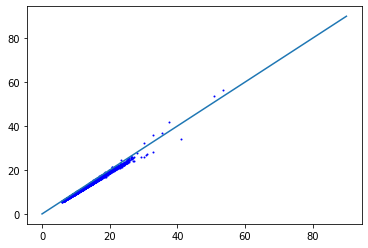

In [264]:
pre = net_1(x_test_tensor)
plt.plot(pre.numpy()[0][::-1].reshape(-1), y_test_resize_tensor.numpy()[0][::-1].reshape(-1),'bo', markersize=1)
plt.plot([0,90],[0,90])


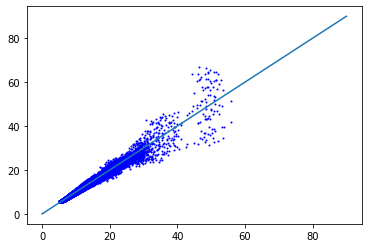

In [265]:
plt.plot(pre.numpy()[::-1].reshape(-1), y_test_resize_tensor.numpy()[::-1].reshape(-1),'bo', markersize=1)
plt.plot([0,90],[0,90])

<AxesSubplot: >

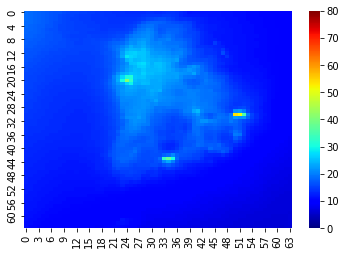

In [266]:
sns.heatmap(pre.numpy().reshape(-1,64,64)[0][::-1], cmap = 'jet',vmin=0, vmax=80)

<AxesSubplot: >

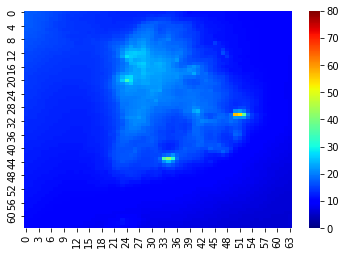

In [267]:
sns.heatmap(y_test_resize_tensor.numpy().reshape(-1,64,64)[0][::-1], cmap = 'jet',vmin=0, vmax=80)

In [268]:
@tf.function()
def train_step(input, label, network, loss_fun):
  
  with tf.GradientTape() as tape:
    ##로스 계산
    pred = network(input)
    
    loss = loss_fun(label, pred)
  grads = tape.gradient(loss, network.trainable_variables)
  optimizer.apply_gradients(zip(grads, network.trainable_variables))
  return loss



loss = tf.keras.losses.MeanSquaredError()
optimizer = tf.keras.optimizers.Adam(0.00005/1000)

for epoc in range(epoch):
    count = 0

    for batch in shuffled_dataset.batch(batch_size).take(n_run):

        count += 1
        mse_loss = train_step(batch[0],batch[1], net_1,loss).numpy()
        print(f"batch: {count}/{n_run} ---epoch: {epoc}/{epoch}--- mse-loss: {mse_loss}")

batch: 1/4.0 ---epoch: 0/1000--- mse-loss: 0.18171048164367676
batch: 2/4.0 ---epoch: 0/1000--- mse-loss: 0.1652420163154602
batch: 3/4.0 ---epoch: 0/1000--- mse-loss: 0.1579245626926422
batch: 4/4.0 ---epoch: 0/1000--- mse-loss: 0.18735234439373016
batch: 1/4.0 ---epoch: 1/1000--- mse-loss: 0.16267409920692444
batch: 2/4.0 ---epoch: 1/1000--- mse-loss: 0.17765364050865173
batch: 3/4.0 ---epoch: 1/1000--- mse-loss: 0.1718083769083023
batch: 4/4.0 ---epoch: 1/1000--- mse-loss: 0.17284289002418518
batch: 1/4.0 ---epoch: 2/1000--- mse-loss: 0.17299406230449677
batch: 2/4.0 ---epoch: 2/1000--- mse-loss: 0.16077890992164612
batch: 3/4.0 ---epoch: 2/1000--- mse-loss: 0.1686783730983734
batch: 4/4.0 ---epoch: 2/1000--- mse-loss: 0.19212959706783295
batch: 1/4.0 ---epoch: 3/1000--- mse-loss: 0.17043699324131012
batch: 2/4.0 ---epoch: 3/1000--- mse-loss: 0.1478579044342041
batch: 3/4.0 ---epoch: 3/1000--- mse-loss: 0.1724657565355301
batch: 4/4.0 ---epoch: 3/1000--- mse-loss: 0.2155436724424362

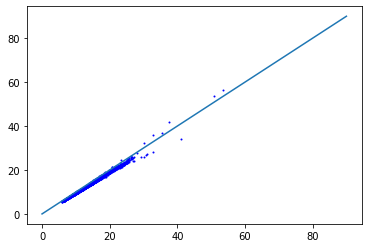

In [269]:
pre = net_1(x_test_tensor)
plt.plot(pre.numpy()[0][::-1].reshape(-1), y_test_resize_tensor.numpy()[0][::-1].reshape(-1),'bo', markersize=1)
plt.plot([0,90],[0,90])


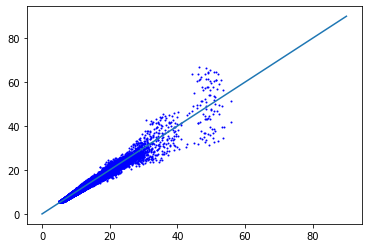

In [270]:
plt.plot(pre.numpy()[::-1].reshape(-1), y_test_resize_tensor.numpy()[::-1].reshape(-1),'bo', markersize=1)
plt.plot([0,90],[0,90])

<AxesSubplot: >

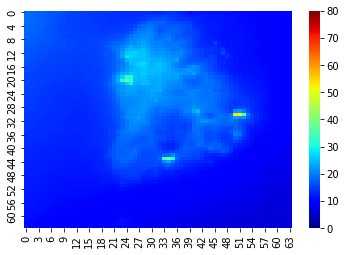

In [271]:
sns.heatmap(pre.numpy().reshape(-1,64,64)[0][::-1], cmap = 'jet',vmin=0, vmax=80)

<AxesSubplot: >

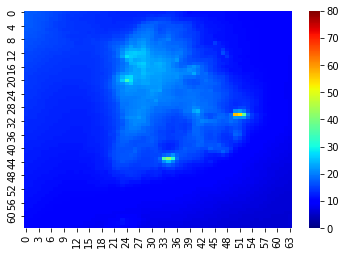

In [272]:
sns.heatmap(y_test_resize_tensor.numpy().reshape(-1,64,64)[0][::-1], cmap = 'jet',vmin=0, vmax=80)

In [273]:
@tf.function()
def train_step(input, label, network, loss_fun):
  
  with tf.GradientTape() as tape:
    ##로스 계산
    pred = network(input)
    
    loss = loss_fun(label, pred)
  grads = tape.gradient(loss, network.trainable_variables)
  optimizer.apply_gradients(zip(grads, network.trainable_variables))
  return loss



loss = tf.keras.losses.MeanSquaredError()
optimizer = tf.keras.optimizers.Adam(0.00005/10000)

for epoc in range(epoch):
    count = 0

    for batch in shuffled_dataset.batch(batch_size).take(n_run):

        count += 1
        mse_loss = train_step(batch[0],batch[1], net_1,loss).numpy()
        print(f"batch: {count}/{n_run} ---epoch: {epoc}/{epoch}--- mse-loss: {mse_loss}")

batch: 1/4.0 ---epoch: 0/1000--- mse-loss: 0.20755144953727722
batch: 2/4.0 ---epoch: 0/1000--- mse-loss: 0.14749297499656677
batch: 3/4.0 ---epoch: 0/1000--- mse-loss: 0.15412919223308563
batch: 4/4.0 ---epoch: 0/1000--- mse-loss: 0.1778964400291443
batch: 1/4.0 ---epoch: 1/1000--- mse-loss: 0.18665647506713867
batch: 2/4.0 ---epoch: 1/1000--- mse-loss: 0.16732433438301086
batch: 3/4.0 ---epoch: 1/1000--- mse-loss: 0.15213914215564728
batch: 4/4.0 ---epoch: 1/1000--- mse-loss: 0.18409697711467743
batch: 1/4.0 ---epoch: 2/1000--- mse-loss: 0.20401115715503693
batch: 2/4.0 ---epoch: 2/1000--- mse-loss: 0.1639760583639145
batch: 3/4.0 ---epoch: 2/1000--- mse-loss: 0.15106745064258575
batch: 4/4.0 ---epoch: 2/1000--- mse-loss: 0.15825772285461426
batch: 1/4.0 ---epoch: 3/1000--- mse-loss: 0.14686228334903717
batch: 2/4.0 ---epoch: 3/1000--- mse-loss: 0.18759283423423767
batch: 3/4.0 ---epoch: 3/1000--- mse-loss: 0.16743449866771698
batch: 4/4.0 ---epoch: 3/1000--- mse-loss: 0.192551523447

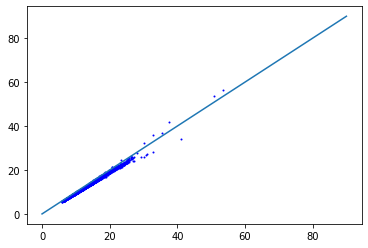

In [274]:
pre = net_1(x_test_tensor)
plt.plot(pre.numpy()[0][::-1].reshape(-1), y_test_resize_tensor.numpy()[0][::-1].reshape(-1),'bo', markersize=1)
plt.plot([0,90],[0,90])


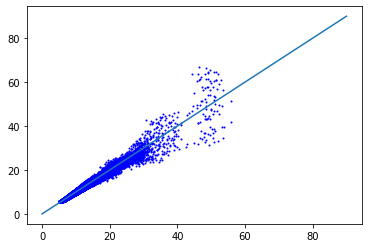

In [275]:
plt.plot(pre.numpy()[::-1].reshape(-1), y_test_resize_tensor.numpy()[::-1].reshape(-1),'bo', markersize=1)
plt.plot([0,90],[0,90])

<AxesSubplot: >

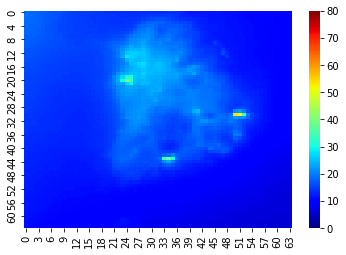

In [276]:
sns.heatmap(pre.numpy().reshape(-1,64,64)[0][::-1], cmap = 'jet',vmin=0, vmax=80)

<AxesSubplot: >

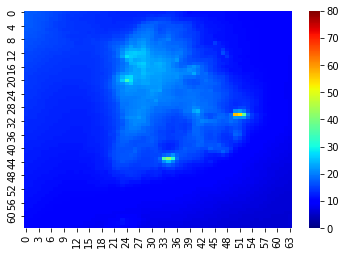

In [277]:
sns.heatmap(y_test_resize_tensor.numpy().reshape(-1,64,64)[0][::-1], cmap = 'jet',vmin=0, vmax=80)